In [1]:
import pandas as pd
import sklearn
import numpy as np
import os
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import lightgbm as lgbm
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import scipy.stats
from sklearn.preprocessing import FunctionTransformer
from scipy.stats.mstats import winsorize 

pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")

In [2]:
%%time
#get data
datasets = r'input'
output = r'output'

hbw_16 = pd.read_csv(os.path.join(datasets,r'data_2016_new.csv'))
hbw_17 = pd.read_csv(os.path.join(datasets,r'data_2017_new.csv'))

Wall time: 3.18 s


# Overview
The notebook will be split in 3 steps:

1) EDA

2) Feature engineering and training & testing

3) Prediction

In the first step, we will do a first analysis of the data, without going too much in detail to avoid the "data snooping" bias. We will build an analytical dataframe (DF), checking for missing values and get a first sense of the distribution. Then we will dig deeper, for instance looking at correlations with target variable.

In the second step, we will work on feature engineering & model training to predict the target variables. Training will be done with cross validation, scoring first in the out-of-fold portion of the data, then on a holdout set.

Upon having chosen the best model(s), we will apply them in the 3rd step to predict the response variable.

### 1) EDA
Let's start with getting an overview of the data. We'll look at a few things:
- missing / fishy values
- the distributions of the variables (to see if we'll need scaling or if anything is odd)
- the distributions of the variables, segmenting for the target variable (does any of the features behave oddly compared vs the target?)
- as a post-hoc diagnostic, in case our model poorly, we could also compare train (2016) vs test data (2017), but to do this before building the model would be a little bit like cheating

We have a total of 200,000 IDs in the train & test datasets, with 54 (+ target and index) fields.
At first sight there'd be very few missing values if we check using the df.info() method, but we know better, as we are already sure that for the "Householdtypology" field missing values are flagged with "!"
And, for the 44 records missing the target variable and the 2 missing the Collishop_customer variable, we can take a quick look since we're dealing about a minimal amount of values.

Let's see how many "fishy" values we can find

In [3]:
hbw_16.shape

(200000, 56)

In [4]:
hbw_17.shape

(200000, 55)

In [5]:
#Collishop_customer is of object type, but it should be a binary int
hbw_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   masked_customer_id               200000 non-null  int64  
 1   jaar                             200000 non-null  int64  
 2   bought_highbrow_wines            199996 non-null  float64
 3   Collishop_customer               199998 non-null  object 
 4   cat_AP_STDR_PortoONLINE          200000 non-null  float64
 5   cat_AP_STDR_WhiskyONLINE         200000 non-null  float64
 6   cat_Babyluiers                   200000 non-null  float64
 7   cat_Ber_Ger_DVPortioneerbaar     200000 non-null  float64
 8   cat_Ber_Ger_VersMaaltijdsalades  200000 non-null  float64
 9   cat_Bier_Genietbieren            200000 non-null  float64
 10  cat_Bloemen                      200000 non-null  float64
 11  cat_Bot_Mar_Boter                200000 non-null  float64
 12  ca

In [6]:
#let's use the ID columns as index (after checking there are no duplicates)

iddups16 = hbw_16[hbw_16['masked_customer_id'].duplicated()].shape[0]
iddups17 = hbw_17[hbw_17['masked_customer_id'].duplicated()].shape[0]

if iddups16 + iddups17 == 0:
    print('no duplicate in ID columns, ok to use as index')
else:
    raise ValueError('duplicates in ID columns')

hbw_16.set_index(hbw_16['masked_customer_id'], inplace=True)
hbw_16.drop(columns=['masked_customer_id'], inplace=True)
hbw_17.set_index(hbw_17['masked_customer_id'], inplace=True)
hbw_17.drop(columns=['masked_customer_id'], inplace=True)

no duplicate in ID columns, ok to use as index


In [7]:
#let's create dfs to "be processed"
hbw_16_proc = hbw_16.copy(deep=True)
hbw_17_proc = hbw_17.copy(deep=True)

In [8]:
#only 5% of the sample bought highbrow wines: we'll have to deal with the rare class problem

hbw_16_proc['bought_highbrow_wines'].value_counts() / hbw_16_proc.shape[0]

0.00   0.95
1.00   0.05
Name: bought_highbrow_wines, dtype: float64

In [9]:
#we might want to transform this to binary
print(hbw_16['Collishop_customer'].value_counts())
print(hbw_17['Collishop_customer'].value_counts())

N    175437
Y     24561
Name: Collishop_customer, dtype: int64
N    175057
Y     24943
Name: Collishop_customer, dtype: int64


In [10]:
#create a real dummy variable
hbw_16_proc['Collishop_customer'] = np.where(hbw_16_proc['Collishop_customer'] == "Y", 1, 0)
hbw_17_proc['Collishop_customer'] = np.where(hbw_17_proc['Collishop_customer'] == "Y", 1, 0)

In [11]:
#the year field looks ok
hbw_16['jaar'].value_counts()

2016    200000
Name: jaar, dtype: int64

In [12]:
#we can already see that ~21% of values are missing
hbw_16['HOUSEHOLDTYPOLOGY'].value_counts()

g_HHnochild_55_plus        60375
!                          41938
k_HHchild_oldest_13_17     22244
j_HHchild_oldest_6_12      18685
f_HHnochild_35_54          17610
c_Single_55_plus           17148
i_HHchild_oldest_0_5       10942
b_Single_35_54              6377
e_HHnochild_18_34           2925
a_Single_18_34              1684
h_HHnochild_nietbepaald       38
d_Single_nietbepaald          34
Name: HOUSEHOLDTYPOLOGY, dtype: int64

In [13]:
hbw_16[hbw_16['HOUSEHOLDTYPOLOGY'] == "!"].shape[0]

41938

In [14]:
#let's see all columns with missing values 

def missing_values(data):
    total = []
    percent = []
    types = []
    
    for col in data.columns:
            total.append(data[data[col].isnull()].shape[0])
            percent.append((data[data[col].isnull()].shape[0]/hbw_16.shape[0]))
            types.append(str(data[col].dtype)) 

    total = pd.Series(total)
    percent = pd.Series(percent)
    types = pd.Series(types)        
    tt = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
    tt = tt[tt['Total'] > 0]
    tt = np.transpose(tt)
    tt.columns = data.iloc[:, tt.columns].columns
    return(tt)

In [15]:
#we have two columns with missing values, very few rows impacted
nas = missing_values(hbw_16)
nas

,bought_highbrow_wines,Collishop_customer
Total,4,2
Percent,0.00,0.00
Type,float64,object


In [16]:
#let's check missing values to decide what to do about them
#something to keep in the back of our mind is: what could have generated them?

missing_ids = hbw_16[(hbw_16['bought_highbrow_wines'].isnull() == True) | (hbw_16['Collishop_customer'].isnull() == True)].index
hbw_16_proc['missing'] = np.where(hbw_16.index.isin(missing_ids), 1, 0)


hbw_16[(hbw_16['bought_highbrow_wines'].isnull() == True) | (hbw_16['Collishop_customer'].isnull() == True)]

,jaar,bought_highbrow_wines,Collishop_customer,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,cat_Bloemen,...,cat_nfokay,total_discount,rev_ticket,prod_ticket,n_cogo,cogo_rev,HOUSEHOLDTYPOLOGY,price_sens_colr,SOW_type_colr,SOW_colr
masked_customer_id,,,,,,,,,,,,,,,,,,,,,
340084,2016,NaN,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-0.55,14.26,4,0,0.00,f_HHnochild_35_54,-0.06,SOW30-40,34
352961,2016,NaN,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,9.89,5,0,0.00,f_HHnochild_35_54,-0.70,SOW00-10,9
362499,2016,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,56.19,3,0,0.00,f_HHnochild_35_54,-0.05,SOW40-50,47
374200,2016,NaN,N,0.00,0.00,0.00,0.00,0.00,83.03,0.00,...,0.00,-3.18,19.64,3,0,0.00,!,-0.03,SOW20-30,26
378393,2016,0.00,NaN,0.00,0.00,0.00,0.00,0.00,44.55,22.44,...,0.00,-3.63,11.10,3,0,0.00,k_HHchild_oldest_13_17,-0.20,SOW70-80,74
209158,2016,NaN,N,0.00,0.00,0.00,0.00,0.00,52.16,0.00,...,0.00,-8.73,19.66,5,0,0.00,k_HHchild_oldest_13_17,-0.50,SOW60-70,63


Since these missing values are very few and relate in good part to the target variable, the right thing to do is to remove them.
We'll have to keep this in mind when preparing the dataframe

In [17]:
%%time

#let's see most fequent/duplicate values per field

features = hbw_16.columns.values
unique_max_train = []

for feature in features:
    values = hbw_16[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax(), str(hbw_16[feature].dtype)])
    
dups = np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value', 'Type'])).\
                sort_values(by = 'Max duplicates', ascending=False)).T           

Wall time: 465 ms


In [18]:
dups

,Feature,Max duplicates,Value,Type
0,jaar,200000,2016,int64
13,cat_ColruytMobile_Toestellen,199998,0,int64
45,cat_nfokay,199934,0.00,float64
3,cat_AP_STDR_PortoONLINE,199877,0.00,float64
4,cat_AP_STDR_WhiskyONLINE,199340,0.00,float64
37,cat_VNCVarkenRest,199269,0.00,float64
26,cat_Textiel_Bedlinnen,199183,0.00,float64
36,cat_VNCRest,198971,0.00,float64
15,cat_EleKtroKeuken,198124,0.00,float64
17,cat_Incontinentie_luiers,197931,0.00,float64


In [19]:
#let's see if other fields contain fishy "!" data 

def fishy_values(data):
    total = []
    percent = []
    types = []
    
    for col in data.columns:
            total.append(data[data[col] == '!'].shape[0])
            percent.append((data[data[col] == '!'].shape[0]/hbw_16.shape[0]))
            types.append(str(data[col].dtype)) 

    total = pd.Series(total)
    percent = pd.Series(percent)
    types = pd.Series(types)        
    tt = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
    tt = tt[tt['Total'] > 0]
    tt = np.transpose(tt)
    tt.columns = data.iloc[:, tt.columns].columns
    return(tt)

In [20]:
#we have two columns with "! values", but it's a sizeable portion of our data
exls = fishy_values(hbw_16)
exls

,HOUSEHOLDTYPOLOGY,SOW_type_colr
Total,41938,1379
Percent,0.21,0.01
Type,object,object


"fishy" missing values are any more than NAs, but are concentrated in two columns.

Let's see if we can find any difference in how these records look like, compared to "filled" records

In [21]:
fishy_ids = hbw_16[(hbw_16['HOUSEHOLDTYPOLOGY'] == "!") | (hbw_16['SOW_type_colr'] == "!")].index
hbw_16[(hbw_16['HOUSEHOLDTYPOLOGY'] == "!") | (hbw_16['SOW_type_colr'] == "!")]

,jaar,bought_highbrow_wines,Collishop_customer,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,cat_Bloemen,...,cat_nfokay,total_discount,rev_ticket,prod_ticket,n_cogo,cogo_rev,HOUSEHOLDTYPOLOGY,price_sens_colr,SOW_type_colr,SOW_colr
masked_customer_id,,,,,,,,,,,,,,,,,,,,,
340024,2016,0.00,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-3.87,6.35,1,0,0.00,!,-0.14,SOW20-30,26
340052,2016,0.00,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,6.47,4,0,0.00,!,-1.00,SOW00-10,6
340256,2016,0.00,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,2.82,1,0,0.00,!,-1.00,SOW00-10,10
340384,2016,0.00,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-1.10,6.86,3,0,0.00,!,-1.00,SOW10-20,12
340727,2016,0.00,N,0.00,0.00,0.00,0.00,0.00,7.98,0.00,...,0.00,0.00,20.58,3,0,0.00,!,-1.00,SOW00-10,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8778160,2016,1.00,N,0.00,0.00,0.00,0.00,0.00,229.53,0.00,...,0.00,0.00,102.44,2,0,0.00,!,-1.00,SOW20-30,25
8781244,2016,1.00,N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,27.23,2,0,0.00,!,-1.00,SOW40-50,49
8783275,2016,1.00,N,0.00,0.00,0.00,0.00,0.00,7.60,5.95,...,0.00,-9.33,97.93,8,0,0.00,!,-1.00,SOW30-40,39


In [22]:
(
hbw_16[(hbw_16['HOUSEHOLDTYPOLOGY'] != "!") | (hbw_16['SOW_type_colr'] != "!")].describe()
-
hbw_16[(hbw_16['HOUSEHOLDTYPOLOGY'] == "!") | (hbw_16['SOW_type_colr'] == "!")].describe()
).T

,count,mean,std,min,25%,50%,75%,max
jaar,"156,683.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
bought_highbrow_wines,"156,680.00",0.00,0.01,0.00,0.00,0.00,0.00,0.00
cat_AP_STDR_PortoONLINE,"156,683.00",0.02,1.81,0.00,0.00,0.00,0.00,448.33
cat_AP_STDR_WhiskyONLINE,"156,683.00",0.12,1.75,0.00,0.00,0.00,0.00,194.90
cat_Babyluiers,"156,683.00",-1.48,-1.38,0.00,0.00,0.00,0.00,0.00
cat_Ber_Ger_DVPortioneerbaar,"156,683.00",0.08,0.44,-0.01,0.00,0.00,0.00,427.95
cat_Ber_Ger_VersMaaltijdsalades,"156,683.00",0.34,0.70,-2.82,0.00,0.00,0.00,141.95
cat_Bier_Genietbieren,"156,683.00",7.15,-14.35,-197.68,0.00,0.00,8.66,0.00
cat_Bloemen,"156,683.00",0.64,2.37,0.00,0.00,0.00,0.00,701.74
cat_Bot_Mar_Boter,"156,683.00",2.35,2.74,-2.35,0.00,1.09,2.93,20.44


In [23]:
(
hbw_16[(hbw_16['HOUSEHOLDTYPOLOGY'] == "!") | (hbw_16['SOW_type_colr'] == "!")].describe()
/
hbw_16[(hbw_16['HOUSEHOLDTYPOLOGY'] != "!") | (hbw_16['SOW_type_colr'] != "!")].describe()
- 1).T

,count,mean,std,min,25%,50%,75%,max
jaar,-0.78,0.00,NaN,0.00,0.00,0.00,0.00,0.00
bought_highbrow_wines,-0.78,-0.08,-0.04,NaN,NaN,NaN,NaN,0.00
cat_AP_STDR_PortoONLINE,-0.78,-0.49,-0.50,NaN,NaN,NaN,NaN,-0.63
cat_AP_STDR_WhiskyONLINE,-0.78,-0.33,-0.18,NaN,NaN,NaN,NaN,-0.22
cat_Babyluiers,-0.78,0.12,0.03,0.00,NaN,NaN,NaN,0.00
cat_Ber_Ger_DVPortioneerbaar,-0.78,-0.19,-0.13,-1.00,NaN,NaN,NaN,-0.74
cat_Ber_Ger_VersMaaltijdsalades,-0.78,-0.23,-0.06,-1.00,NaN,NaN,NaN,-0.14
cat_Bier_Genietbieren,-0.78,-0.20,0.10,-0.96,NaN,NaN,-0.38,0.00
cat_Bloemen,-0.78,-0.28,-0.21,NaN,NaN,NaN,NaN,-0.70
cat_Bot_Mar_Boter,-0.78,-0.20,-0.10,-1.00,NaN,-0.52,-0.27,-0.02


Looking at the means and std deviations for the fishy "!" values vs non-!, we can see that they do behave differently

Let's do some visual inspection

In [24]:
#let's create a flag for fishy
hbw_16_proc['fishy'] = np.where(hbw_16.index.isin(fishy_ids), 1, 0)

#let's make a plotting function
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(9,6,figsize=(22,24))

    for feature in features:
        i += 1
        plt.subplot(9,6,i)
        sns.kdeplot(data=df1[feature], label=label1, warn_singular=False)
        sns.kdeplot(data=df2[feature], label=label2, warn_singular=False)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

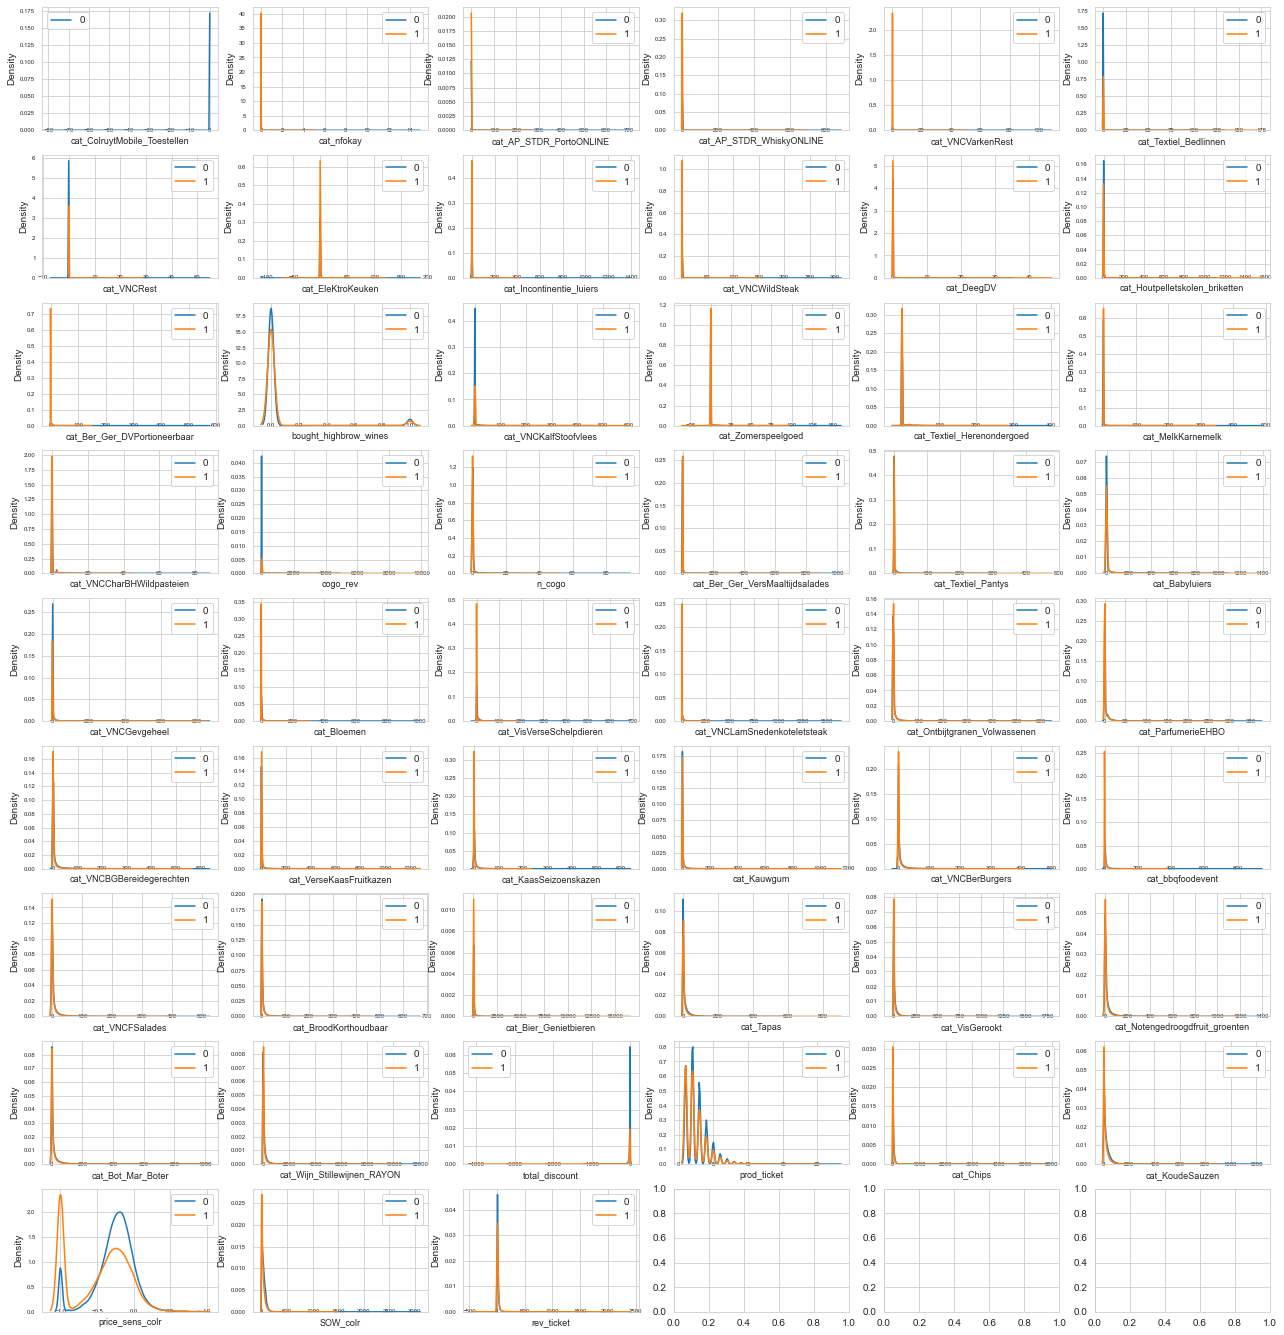

Wall time: 2min 43s


In [25]:
%%time
#let's look at the distribution of numerical variables

t0 = hbw_16_proc.loc[(hbw_16_proc['fishy'] == 0) & (hbw_16_proc['missing'] == 0)]
t1 = hbw_16_proc.loc[(hbw_16_proc['fishy'] == 1) & (hbw_16_proc['missing'] == 0)]
features = dups[dups['Type'] != 'object']['Feature'].values[1:]
plot_feature_distribution(t0, t1, '0', '1', features)

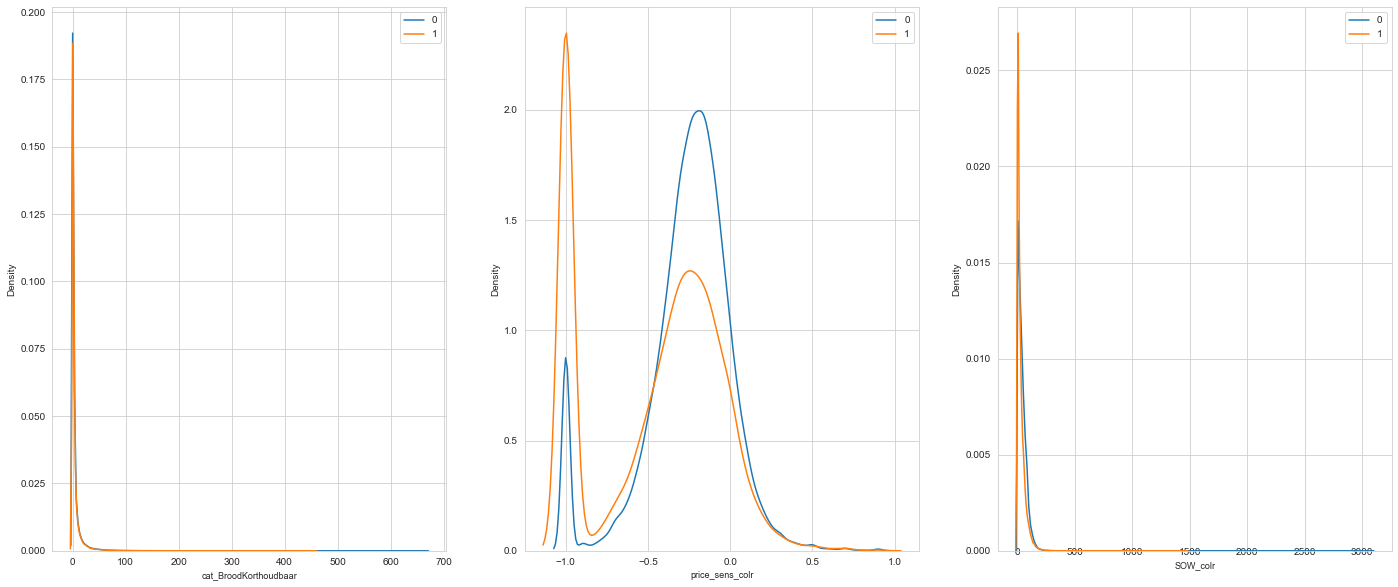

In [26]:
#let's deep dive on a few fields 
#some fields are reasonably similar, others show tangible differences


fig, ax = plt.subplots(1,2,figsize=(24,10))
plt.subplot(1,3,1)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['fishy'] == 0]['cat_BroodKorthoudbaar'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['fishy'] == 1]['cat_BroodKorthoudbaar'], label='1')
plt.xlabel('cat_BroodKorthoudbaar', fontsize=9)
plt.legend()
plt.subplot(1,3,2)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['fishy'] == 0]['price_sens_colr'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['fishy'] == 1]['price_sens_colr'], label='1')
plt.xlabel('price_sens_colr', fontsize=9)
plt.legend()
plt.subplot(1,3,3)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['fishy'] == 0]['SOW_colr'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['fishy'] == 1]['SOW_colr'], label='1')
plt.xlabel('SOW_colr', fontsize=9)
plt.legend()
locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', pad=-6)
plt.tick_params(axis='y', which='major')
plt.show()

Tackling "fishy" values will be harder than tackling the 6 missing values

Not only do they affect a sizeable portion of the dataset, but also they show a different behavior vis-a-vis the response variable, for certain fields

Potential ways of tackling this:
- imputing
- removing affected fields (let's see how they relate with the response variables)
- removing affected rows

The best way to decide would be to test models for each scenario.

Nevertheless, we should flag "!" as missing from here on

In [27]:
hbw_16_proc.loc[hbw_16_proc['HOUSEHOLDTYPOLOGY'] == '!', 'HOUSEHOLDTYPOLOGY'] = np.NaN
hbw_16_proc.loc[hbw_16_proc['SOW_type_colr'] == '!', 'SOW_type_colr'] = np.NaN

hbw_17_proc.loc[hbw_17_proc['SOW_type_colr'] == '!', 'SOW_type_colr'] = np.NaN
hbw_17_proc.loc[hbw_17_proc['HOUSEHOLDTYPOLOGY'] == '!', 'HOUSEHOLDTYPOLOGY'] = np.NaN

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

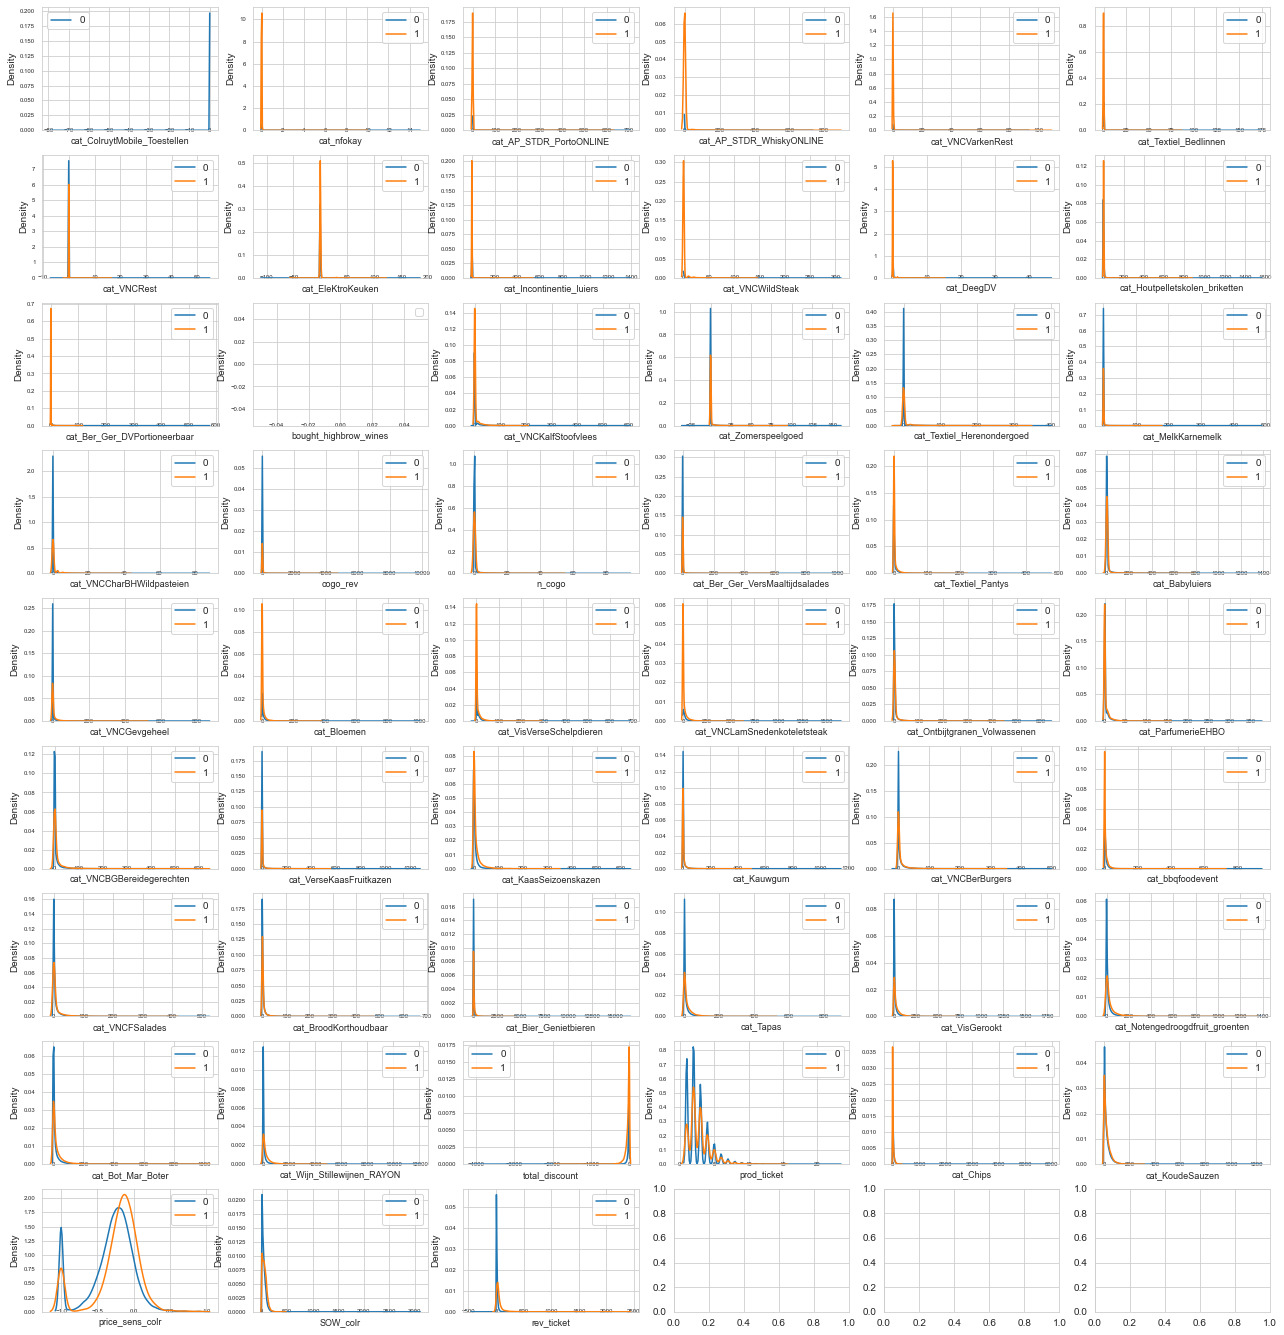

Wall time: 2min 40s


In [28]:
%%time
#let's now look at how  the features relate to the target variable

t0 = hbw_16_proc.loc[(hbw_16_proc['bought_highbrow_wines'] == 0) & (hbw_16_proc['missing'] == 0)]
t1 = hbw_16_proc.loc[(hbw_16_proc['bought_highbrow_wines'] == 1) & (hbw_16_proc['missing'] == 0)]
features = dups[dups['Type'] != 'object']['Feature'].values[1:]
plot_feature_distribution(t0, t1, '0', '1', features)

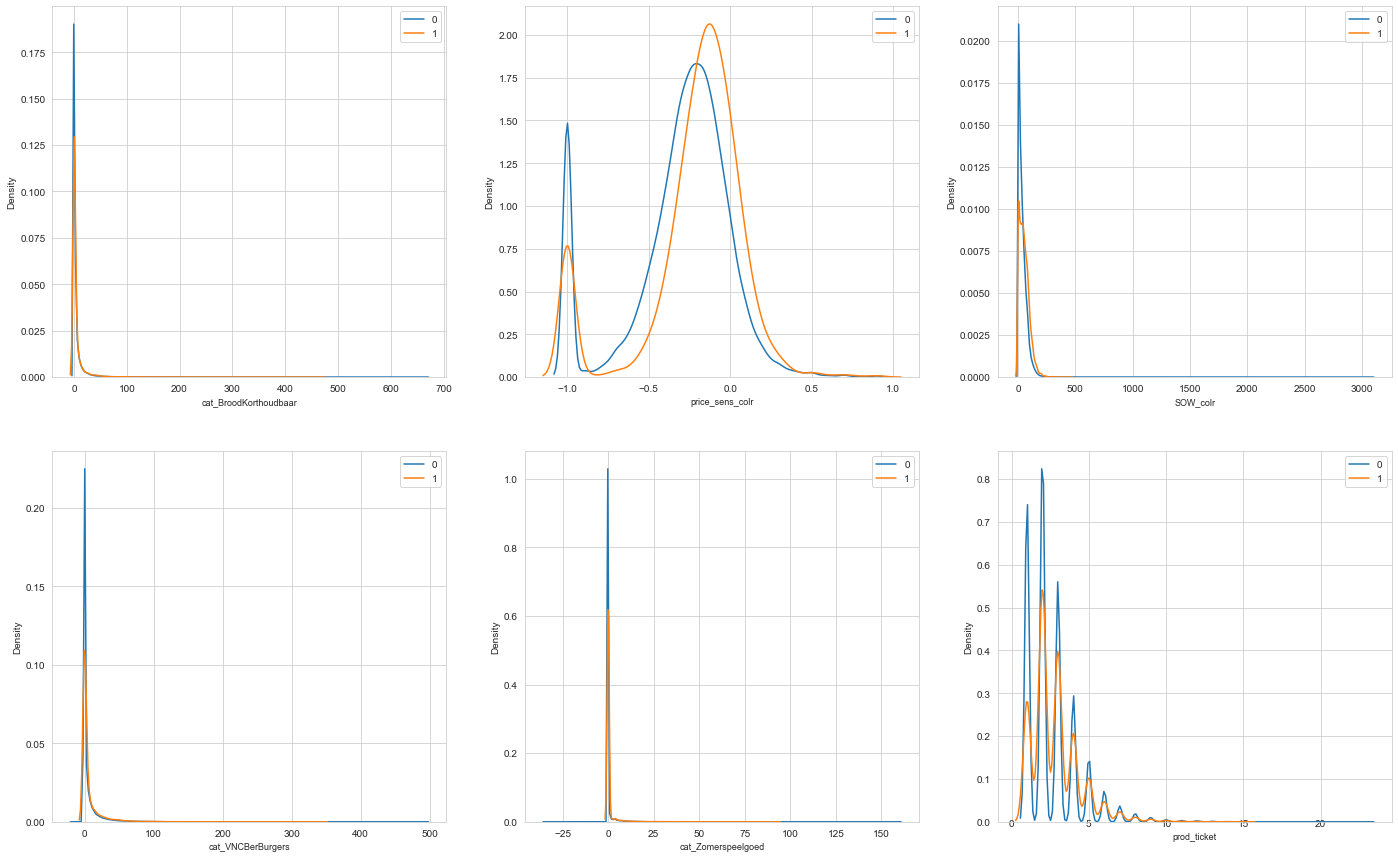

Wall time: 18.1 s


In [29]:
%%time

fig, ax = plt.subplots(1,2,figsize=(24,15))
plt.subplot(2,3,1)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['cat_BroodKorthoudbaar'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['cat_BroodKorthoudbaar'], label='1')
plt.xlabel('cat_BroodKorthoudbaar', fontsize=9)
plt.legend()

plt.subplot(2,3,2)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['price_sens_colr'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['price_sens_colr'], label='1')
plt.xlabel('price_sens_colr', fontsize=9)
plt.legend()

plt.subplot(2,3,3)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['SOW_colr'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['SOW_colr'], label='1')
plt.xlabel('SOW_colr', fontsize=9)
plt.legend()

plt.subplot(2,3,4)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['cat_VNCBerBurgers'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['cat_VNCBerBurgers'], label='1')
plt.xlabel('cat_VNCBerBurgers', fontsize=9)
plt.legend()

plt.subplot(2,3,5)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['cat_Zomerspeelgoed'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['cat_Zomerspeelgoed'], label='1')
plt.xlabel('cat_Zomerspeelgoed', fontsize=9)
plt.legend()

plt.subplot(2,3,6)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['prod_ticket'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['prod_ticket'], label='1')
plt.xlabel('prod_ticket', fontsize=9)
plt.legend()

locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', pad=-6)
plt.tick_params(axis='y', which='major')
plt.show()

In [30]:
hbw_16['prod_ticket']

masked_customer_id
339806     6
339807     2
339809     1
339812     1
339815     4
          ..
8781244    2
8783275    8
8786290    3
8794070    3
8794346    3
Name: prod_ticket, Length: 200000, dtype: int64

In [31]:
#list of all product columns to generate revenues

catcols = hbw_16_proc.iloc[:, 3:46].columns

In [32]:
sums = []

for col in catcols:
    sums.append(hbw_16_proc[col].sum())
    
sizes = pd.DataFrame(sums, index=catcols, columns=['Sum of sales'])
sizes.sort_values('Sum of sales', ascending=False)

,Sum of sales
cat_Wijn_Stillewijnen_RAYON,"16,977,007.19"
cat_Bier_Genietbieren,"7,299,276.18"
cat_Chips,"4,000,503.30"
cat_KoudeSauzen,"3,687,255.98"
cat_Notengedroogdfruit_groenten,"3,570,475.32"
cat_VisGerookt,"2,601,807.88"
cat_Babyluiers,"2,398,634.31"
cat_Bot_Mar_Boter,"2,395,983.84"
cat_Tapas,"1,844,460.04"
cat_VNCFSalades,"1,292,514.64"


total sales by category differ a lot, so we will deepdive on a few soon.

However, for mobile appliances total sales are negative. While this is not impossible 
(e.g. returns / warranties), it is a bit surprising that the full category is negative.
Looking at the values, we have 2 -79 and all the rest are 0
These data look odd, therefore the best option would be consulting a domain expert. In the absence of this possibility, we should seriously consider leaving it out

In [33]:
hbw_16_proc['cat_ColruytMobile_Toestellen'].value_counts()

 0     199998
-79         2
Name: cat_ColruytMobile_Toestellen, dtype: int64

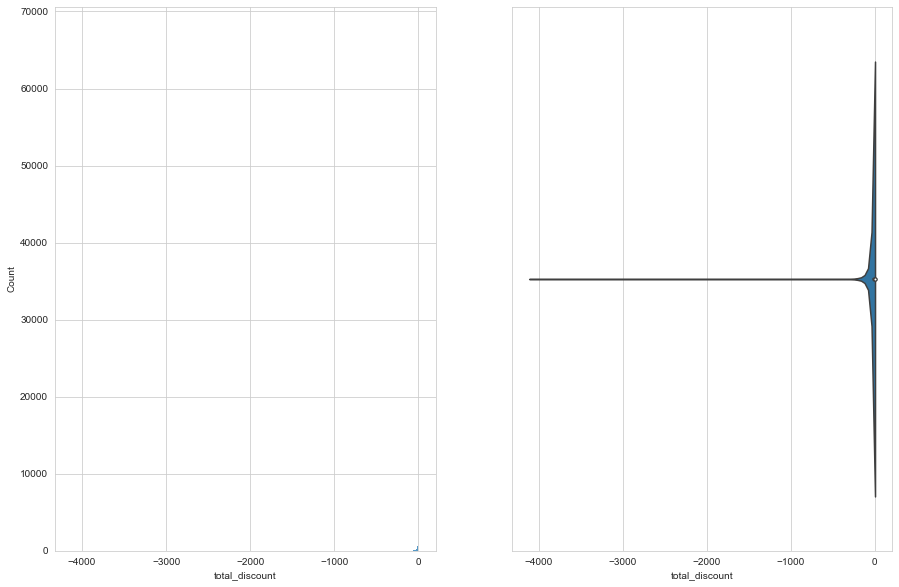

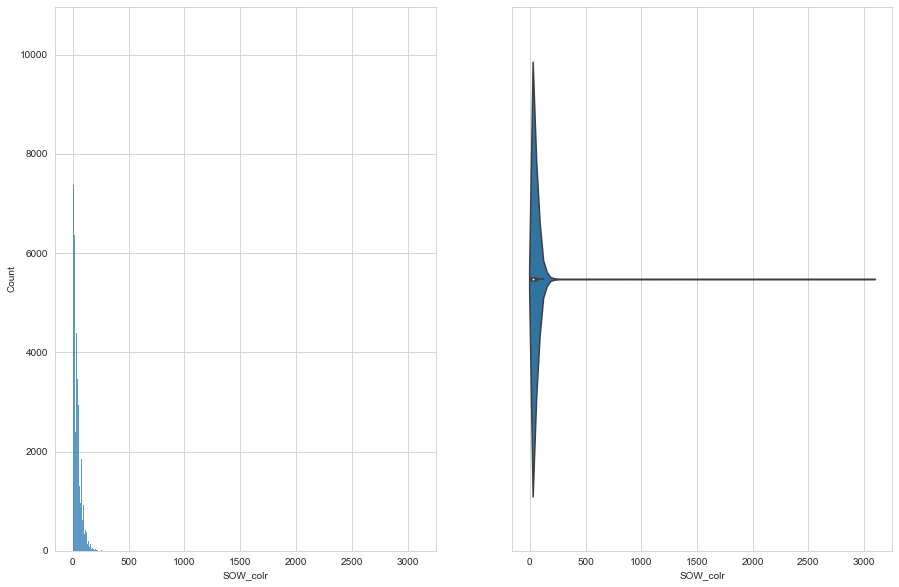

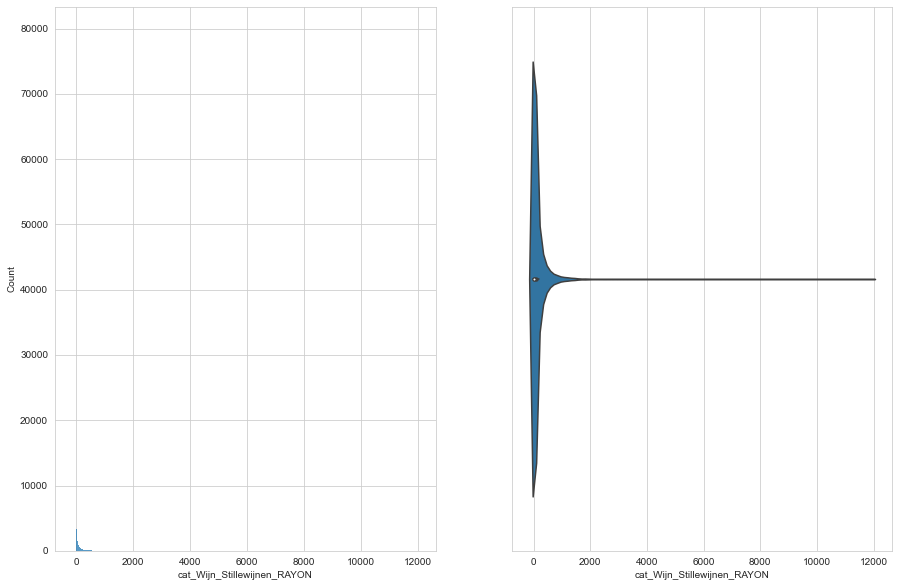

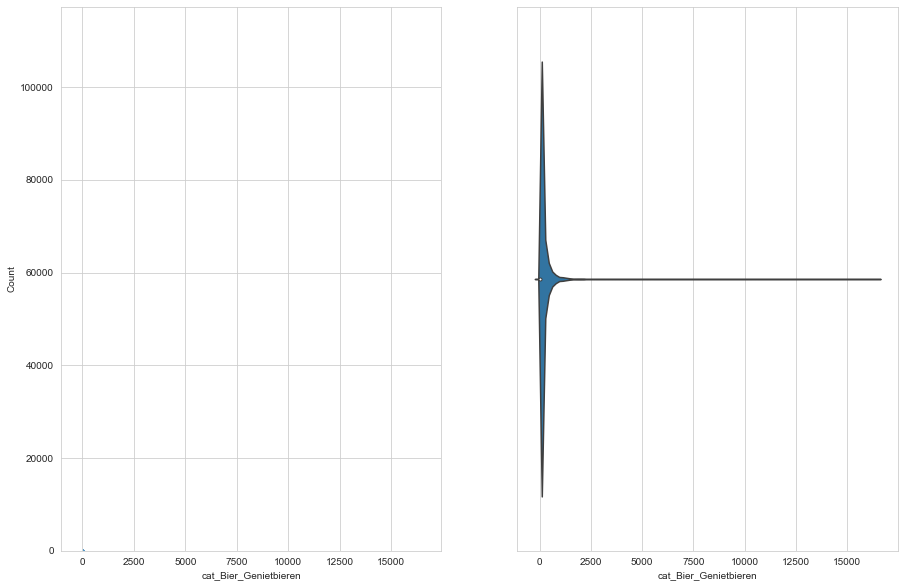

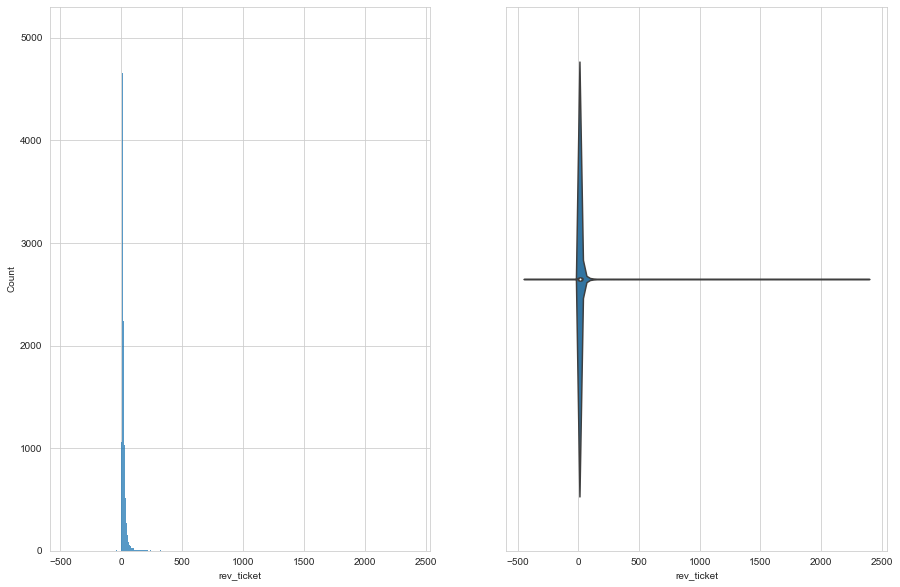

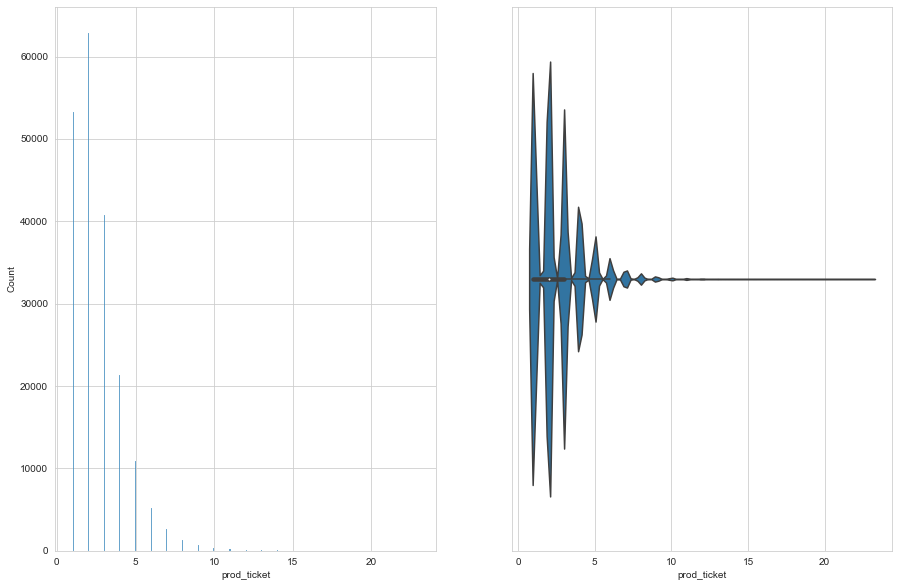

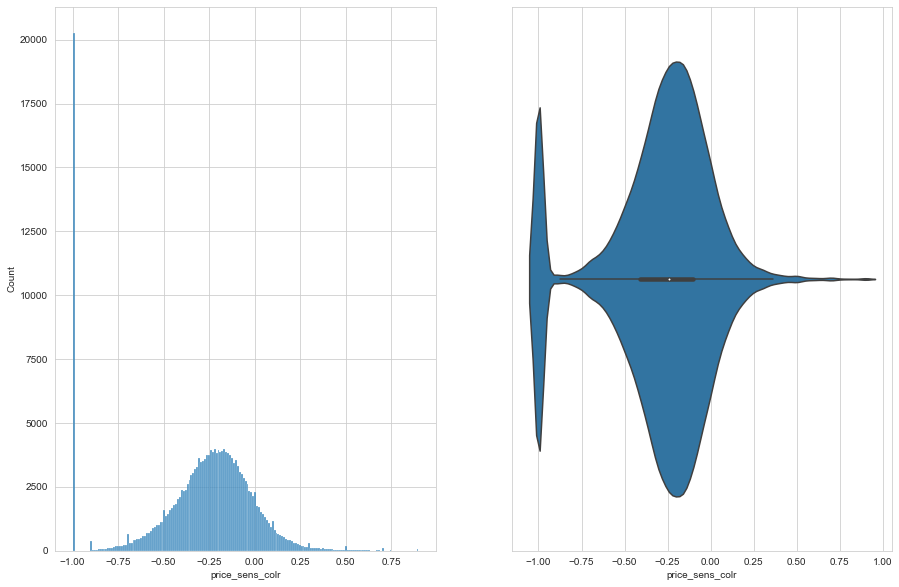

Wall time: 1min 52s


In [34]:
%%time
#let's look in depth at how a few variables are distributed

feature_list = ['total_discount', 'SOW_colr',
                'cat_Wijn_Stillewijnen_RAYON', 'cat_Bier_Genietbieren',
                'rev_ticket', 'prod_ticket', 'price_sens_colr']
i = 0


for feature in feature_list:
    fig, ax = plt.subplots(1,2,figsize=(15,10))
    plt.subplot(1,2,1)
    sns.histplot(x=hbw_16_proc[feature])
    plt.subplot(1,2,2)
    sns.violinplot(x=hbw_16_proc[feature])
    plt.show()

In [35]:
#if we look at the household typology variable, for people who bought HBW and have a value, almost half are single over 55
#something to keep in mind ;) 

In [36]:
hbw_16_proc['HOUSEHOLDTYPOLOGY'].value_counts() / hbw_16_proc.shape[0]

g_HHnochild_55_plus       0.30
k_HHchild_oldest_13_17    0.11
j_HHchild_oldest_6_12     0.09
f_HHnochild_35_54         0.09
c_Single_55_plus          0.09
i_HHchild_oldest_0_5      0.05
b_Single_35_54            0.03
e_HHnochild_18_34         0.01
a_Single_18_34            0.01
h_HHnochild_nietbepaald   0.00
d_Single_nietbepaald      0.00
Name: HOUSEHOLDTYPOLOGY, dtype: float64

In [37]:
hbw_16_proc[hbw_16_proc['bought_highbrow_wines'] == 1]['HOUSEHOLDTYPOLOGY'].value_counts() / hbw_16_proc[hbw_16_proc['bought_highbrow_wines'] == 1].shape[0]

g_HHnochild_55_plus      0.47
k_HHchild_oldest_13_17   0.09
f_HHnochild_35_54        0.08
c_Single_55_plus         0.07
j_HHchild_oldest_6_12    0.06
i_HHchild_oldest_0_5     0.04
b_Single_35_54           0.02
e_HHnochild_18_34        0.01
a_Single_18_34           0.00
Name: HOUSEHOLDTYPOLOGY, dtype: float64

<AxesSubplot:xlabel='HOUSEHOLDTYPOLOGY', ylabel='Count'>

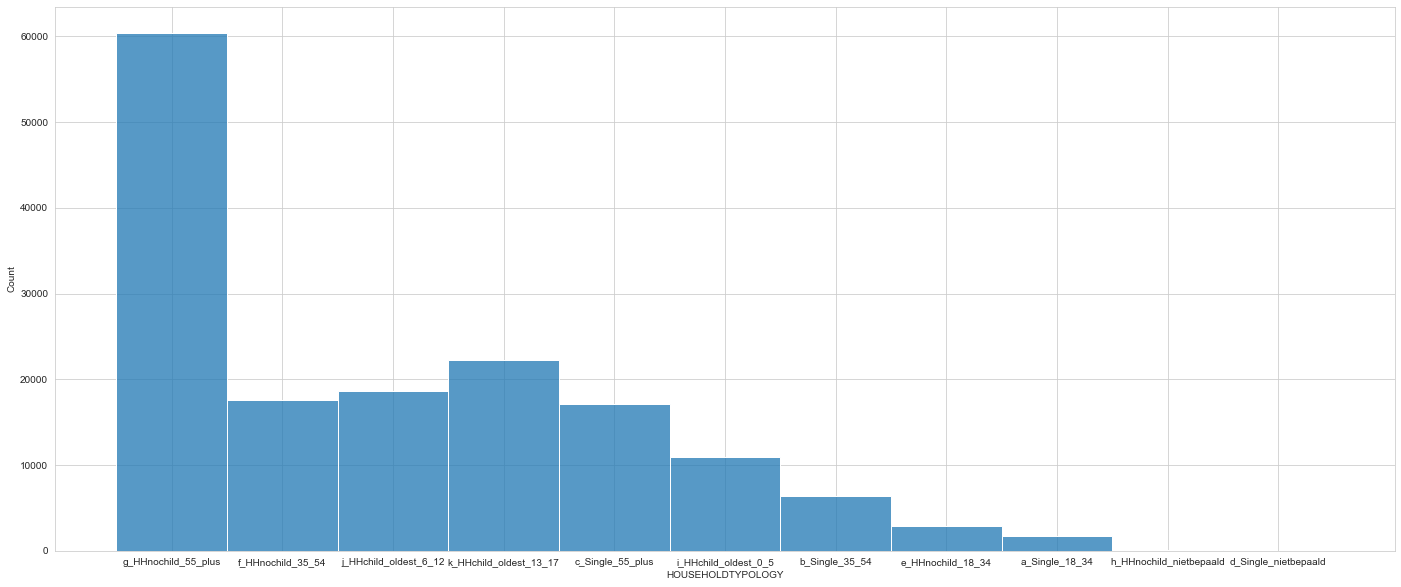

In [38]:
plt.figure(figsize=[24,10])
sns.histplot(hbw_16_proc['HOUSEHOLDTYPOLOGY'])

# let's look at the outliers


In [39]:
hbw_16['SOW_type_colr'].value_counts()

SOW00-10      43666
SOW10-20      31253
SOW20-30      25550
SOW30-40      21136
SOW40-50      17131
SOW50-60      14017
SOW60-70      11373
SOW_100+       9836
SOW70-80       8605
SOW80-90       7162
SOW90-100      4580
Outlier_fr     2490
Outlier_om     1822
!              1379
Name: SOW_type_colr, dtype: int64

In [40]:
#let's look at the outliers
#and not forget that we already removed "!", which are "even more outliers"

outliers = ['Outlier_fr', 'Outlier_om']

print('Mean SOW {}'.format(hbw_16_proc['SOW_colr'].mean()))
print('Mean SOW for turnover outliers {}'.format(hbw_16_proc[hbw_16_proc['SOW_type_colr'] == 'Outlier_om']['SOW_colr'].mean()))
print('Mean SOW for freq outliers {}'.format(hbw_16_proc[hbw_16_proc['SOW_type_colr'] == 'Outlier_fr']['SOW_colr'].mean()))
print('Mean SOW for real outliers {}'.format(hbw_16_proc[hbw_16_proc['SOW_type_colr'].isnull()]['SOW_colr'].mean()))

Mean SOW 38.994955
Mean SOW for turnover outliers 200.57135016465423
Mean SOW for freq outliers 88.14417670682731
Mean SOW for real outliers 0.0


In [41]:
#some SOWs are not really... shares, or percentages. This is odd. Let's create a sales variable and investigate
hbw_16_proc['SOW_colr'].sort_values(ascending=False).head(10)

masked_customer_id
2557911    3092
7286619    1480
1662141    1470
4741619    1425
6255936    1378
6641429    1316
897481     1286
928048     1188
7082937    1141
1391763    1010
Name: SOW_colr, dtype: int64

In [42]:
hbw_16_proc[hbw_16_proc['SOW_colr'] > 100].shape

(12362, 57)

In [43]:
%%time
#let's create a total sales variable

hbw_16_proc['tot_rev'] = hbw_16_proc[catcols].sum(axis=1)
hbw_17_proc['tot_rev'] = hbw_17_proc[catcols].sum(axis=1)

Wall time: 249 ms


In [44]:
#hence there are values with a very high SOW, which do buy a lot
#we need to use these SOW variables with caution (we should consult a domain expert), because while there seems to be a logic to them,
#a percentage should not be >100

print('Mean sales {}'.format(hbw_16_proc['tot_rev'].mean()))
print('Mean sales for SOW > 100 {}'.format(hbw_16_proc[hbw_16_proc['SOW_colr'] > 100]['tot_rev'].mean()))
print('Mean sales for turnover outliers {}'.format(hbw_16_proc[hbw_16_proc['SOW_type_colr'] == 'Outlier_om']['tot_rev'].mean()))
print('Mean sales for freq outliers {}'.format(hbw_16_proc[hbw_16_proc['SOW_type_colr'] == 'Outlier_fr']['tot_rev'].mean()))
print('Mean sales for real outliers {}'.format(hbw_16_proc[hbw_16_proc['SOW_type_colr'].isnull()]['tot_rev'].mean()))

Mean sales 289.11544445000334
Mean sales for SOW > 100 1068.3197403332847
Mean sales for turnover outliers 1735.674934138311
Mean sales for freq outliers 712.8991726907636
Mean sales for real outliers 72.2422987672226


In [45]:
#for the missing SOW type,we don't have a SOW: for this field, 0 means missing value!
hbw_16_proc[hbw_16_proc['SOW_type_colr'].isnull()]['SOW_colr'].shape

(1379,)

In [46]:
#let's flag missing values as NAs

hbw_16_proc.loc[hbw_16_proc['SOW_colr'] == 0, 'SOW_colr'] = np.NaN
hbw_17_proc.loc[hbw_17_proc['SOW_colr'] == 0, 'SOW_colr'] = np.NaN

In [47]:
%%time
#final step: let's build a correlation matrix

features = list(dups[dups['Type'] != 'object']['Feature'].values[1:])
features.append('tot_rev')

correlations = hbw_16_proc[features].corr().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

#top correlations
correlations.head(15)

Wall time: 1.99 s


,level_0,level_1,0
52,n_cogo,cogo_rev,0.78
53,cogo_rev,n_cogo,0.78
54,cat_Wijn_Stillewijnen_RAYON,tot_rev,0.78
55,tot_rev,cat_Wijn_Stillewijnen_RAYON,0.78
56,SOW_colr,tot_rev,0.73
57,tot_rev,SOW_colr,0.73
58,tot_rev,cat_Bier_Genietbieren,0.58
59,cat_Bier_Genietbieren,tot_rev,0.58
60,cat_KoudeSauzen,SOW_colr,0.58
61,SOW_colr,cat_KoudeSauzen,0.58


In [48]:
correlations[correlations['level_0'] == 'bought_highbrow_wines']

,level_0,level_1,0
107,bought_highbrow_wines,rev_ticket,0.31
346,bought_highbrow_wines,tot_rev,0.16
356,bought_highbrow_wines,cat_Wijn_Stillewijnen_RAYON,0.16
461,bought_highbrow_wines,cat_KaasSeizoenskazen,0.13
588,bought_highbrow_wines,cat_VNCLamSnedenkoteletsteak,0.11
645,bought_highbrow_wines,cat_AP_STDR_WhiskyONLINE,0.10
689,bought_highbrow_wines,SOW_colr,0.10
699,bought_highbrow_wines,cat_VisGerookt,0.10
717,bought_highbrow_wines,cat_Tapas,0.10
821,bought_highbrow_wines,cat_Notengedroogdfruit_groenten,0.08


Wall time: 3.41 s


[Text(0.5, 0, 'cat_ColruytMobile_Toestellen'),
 Text(1.5, 0, 'cat_nfokay'),
 Text(2.5, 0, 'cat_AP_STDR_PortoONLINE'),
 Text(3.5, 0, 'cat_AP_STDR_WhiskyONLINE'),
 Text(4.5, 0, 'cat_VNCVarkenRest'),
 Text(5.5, 0, 'cat_Textiel_Bedlinnen'),
 Text(6.5, 0, 'cat_VNCRest'),
 Text(7.5, 0, 'cat_EleKtroKeuken'),
 Text(8.5, 0, 'cat_Incontinentie_luiers'),
 Text(9.5, 0, 'cat_VNCWildSteak'),
 Text(10.5, 0, 'cat_DeegDV'),
 Text(11.5, 0, 'cat_Houtpelletskolen_briketten'),
 Text(12.5, 0, 'cat_Ber_Ger_DVPortioneerbaar'),
 Text(13.5, 0, 'bought_highbrow_wines'),
 Text(14.5, 0, 'cat_VNCKalfStoofvlees'),
 Text(15.5, 0, 'cat_Zomerspeelgoed'),
 Text(16.5, 0, 'cat_Textiel_Herenondergoed'),
 Text(17.5, 0, 'cat_MelkKarnemelk'),
 Text(18.5, 0, 'cat_VNCCharBHWildpasteien'),
 Text(19.5, 0, 'cogo_rev'),
 Text(20.5, 0, 'n_cogo'),
 Text(21.5, 0, 'cat_Ber_Ger_VersMaaltijdsalades'),
 Text(22.5, 0, 'cat_Textiel_Pantys'),
 Text(23.5, 0, 'cat_Babyluiers'),
 Text(24.5, 0, 'cat_VNCGevgeheel'),
 Text(25.5, 0, 'cat_Bloemen'),

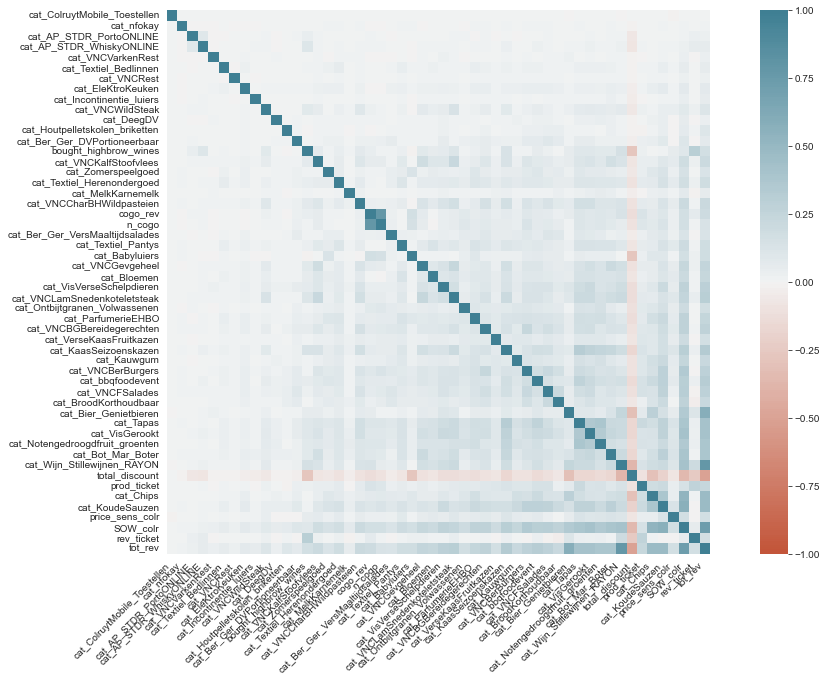

In [49]:
%%time

#between the correlation heatmap here, and the correlations among variables we can see that:
#1) discount correlate negatively to everything (surprise!)
#2) wine correlates to wine (also, surprise), but also to big customers (less of a surprise)
#3) let's keep this in the back of our head for the feature engineering

from matplotlib import rcParams

corr = hbw_16_proc[features].corr()
fig, ax = plt.subplots(figsize=(18,10))    
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# EDA status point

We identified missing values in multiple fields, including critical ones like the target fields, as well as "hidden" missing values (SOW_colr).
We also have an idea on how to tackle this, per the different fields

Additionally, "fishy" records having "!" as value in certain columns, mainly household type have been identified, and we know they behave differently than normal values. Dealing with these will be a tad harder, but again there are options.

We also looked at the variable distributions, both in general and versus the target variable. 

Then, we looked at some odd values we have in the SOW, where some "percentages" are above 1. While this happens for customers who buy a lot, this should not be possible. 

Finally, we looked a bit at the correlation matrix, which gave us a few insights about candidate variables to "play with" during EDA

We now have a much greater knowledge of the data at hand, and can start working on it with a minimum of confidence

# Feature engineering

We actually did a little bit of feature engineering: we created a total sales variable, by summing sales across categories. Now we'll go deeper

Let's kick off the works by creating a baseline model to compare our results to, something basic and only using quantitative columns.

In [50]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

quant_cols = features

hbw_16_proc_baseline = hbw_16_proc.drop(columns=['HOUSEHOLDTYPOLOGY']).dropna()

X_train, X_test, y_train, y_test = train_test_split(hbw_16_proc_baseline[features].drop(columns=['bought_highbrow_wines']), 
                                                    hbw_16_proc_baseline['bought_highbrow_wines'], test_size=0.3, random_state=42)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)


print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    131370
         1.0       0.22      0.76      0.34      6563

    accuracy                           0.86    137933
   macro avg       0.60      0.81      0.63    137933
weighted avg       0.95      0.86      0.89    137933

0.8118779778466781
Wall time: 5.03 s


Our baseline model has a ROC AUC score of 81%, with an overall accuracy of 86% ON TRAINING DATA

The difference in the effectiveness between the two categories, as well as the precision-recall difference show us how much we can (have to) improve
Good luck telling marketeers that when we say "good lead", the customer is a good lead in only 22% of cases ;)

Let's look at the thresholds to understand a bit more

In [51]:
predictions_train = clf.predict_proba(X_train)[:,1]

preds = []
tresh = 0.5

for i in predictions_train:
    if i > tresh:
        preds.append(1)
    else:
        preds.append(0)

print(classification_report(y_train, preds))
print(sklearn.metrics.roc_auc_score(y_train, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    131370
         1.0       0.22      0.76      0.34      6563

    accuracy                           0.86    137933
   macro avg       0.60      0.81      0.63    137933
weighted avg       0.95      0.86      0.89    137933

0.8132720744085719


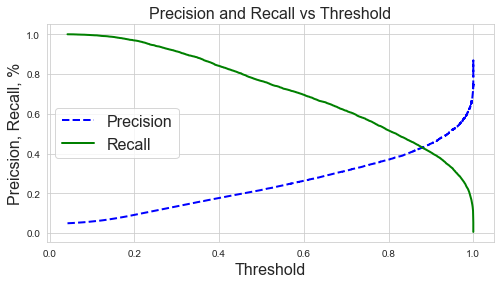

In [52]:
#let's take a look at the precision & recall trade thresholds
#with our current model, the highest precision we can get is not even 50%
#good! that means we have our work cut our for us

from sklearn.metrics import precision_recall_curve

preds = clf.predict_proba(X_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, preds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [53]:
#let's look at the coefficients

coefficients = pd.concat([pd.DataFrame(hbw_16_proc_baseline[features].drop(columns=['bought_highbrow_wines']).columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Var', 'Coef']
coefficients.sort_values(by='Coef', ascending=False)

,Var,Coef
49,rev_ticket,1.94
47,price_sens_colr,0.35
48,SOW_colr,0.22
38,cat_Tapas,0.19
3,cat_AP_STDR_WhiskyONLINE,0.19
31,cat_KaasSeizoenskazen,0.19
2,cat_AP_STDR_PortoONLINE,0.16
41,cat_Bot_Mar_Boter,0.12
26,cat_VNCLamSnedenkoteletsteak,0.10
40,cat_Notengedroogdfruit_groenten,0.09


So, we run a baseline model to have benchmark. 
The performance is definitely too bad for the use case at hand, but we have some extra information thanks to coefficients.

If we look at the most important ones
- Rev ticket (+)
- price sensitivity (+)
- whisky, porto, cheese, and tapas: likely related products, all around the "apero theme"
- basket size (-)
- discount (-)
- diapers (-)
- still wines in store (-)

We know a few related products, and we know that basket size is strongly negatively correlated to high brow wine sales. High brow wines also tend to be bought around an "apero theme", if we look at which products are most correlated, and people tend to spend quite a bit when they buy (but not buy too much, as the total revenue variable is positively correlated), despite higher price sensitivity

Wall time: 5.54 s


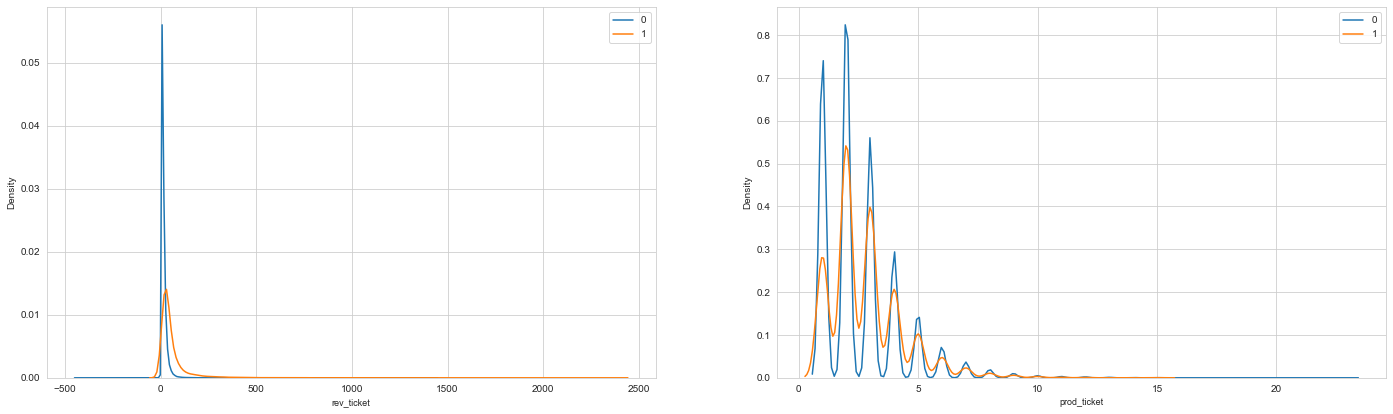

In [54]:
%%time

fig, ax = plt.subplots(1,2,figsize=(24,15))
plt.subplot(2,2,1)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['rev_ticket'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['rev_ticket'], label='1')
plt.xlabel('rev_ticket', fontsize=9)
plt.legend()

plt.subplot(2,2,2)
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 0]['prod_ticket'], label='0')
sns.kdeplot(data=hbw_16_proc.loc[hbw_16_proc['bought_highbrow_wines'] == 1]['prod_ticket'], label='1')
plt.xlabel('prod_ticket', fontsize=9)
plt.legend()

In [55]:
hbw_16_proc[hbw_16_proc['bought_highbrow_wines'] == 0]['rev_ticket'].describe()

count   190,037.00
mean         15.37
std          18.02
min        -446.40
25%           6.66
50%          11.30
75%          18.78
max       1,443.76
Name: rev_ticket, dtype: float64

In [56]:
hbw_16_proc[hbw_16_proc['bought_highbrow_wines'] == 1]['rev_ticket'].describe()

count   9,959.00
mean       59.06
std       104.90
min        -8.13
25%        19.90
50%        31.72
75%        57.96
max     2,393.25
Name: rev_ticket, dtype: float64

In [57]:
#if we look at the rev_ticket variable, there look like to be negative values, which is odd
#same for our total revenue variable

no_revs = hbw_16_proc[hbw_16_proc['tot_rev'] <= 0]
no_rev_ticket = hbw_16_proc[hbw_16_proc['rev_ticket'] <= 0]
zeros = set(no_revs.index.append(no_rev_ticket.index))

print(no_revs.shape)
print(no_rev_ticket.shape)

(1629, 58)
(236, 58)


In [58]:
#almost half of the "zero sales" rows are outliers
#this is good indication that they're indeed weird values
#ideally, we'd consult a domain expert before taking further steps [not all outliers are bad], 
#but lacking this option, it'd be fair to seriously consider removing them
#however, these records represent a significant part of our positive samples, and 40% of them buy HBW
#it's therefore dangerous to remove them (and indeed, if we do, model metrics drop) - so we keep them

print(hbw_16_proc[(hbw_16_proc.index.isin(zeros))]['SOW_type_colr'].value_counts().sum())
print(hbw_16_proc[(hbw_16_proc.index.isin(zeros))].shape)

771
(1672, 58)


In [59]:
hbw_16_proc['bought_highbrow_wines'].value_counts()

0.00    190037
1.00      9959
Name: bought_highbrow_wines, dtype: int64

In [60]:
hbw_16_proc[hbw_16_proc.index.isin(zeros)]['bought_highbrow_wines'].value_counts()

0.00    1016
1.00     656
Name: bought_highbrow_wines, dtype: int64

In [61]:
656 / (1016+656)

0.3923444976076555

In [62]:
#we now identified "bad" outliers and have an idea about what to do with them (for the rest of the data, we can winsorize)
#for missing values in the household typology field, we know they values are distributed differently 
#would be risky to blindly inpute
#let's see what happens if we re-run the baseline, removing those rows
#minimal difference, so we're not that obliged to keep those records

hbw_16_proc_baseline = hbw_16_proc.dropna()

X_train, X_test, y_train, y_test = train_test_split(hbw_16_proc_baseline[features].drop(columns=['bought_highbrow_wines']), 
                                                    hbw_16_proc_baseline['bought_highbrow_wines'], test_size=0.3, random_state=42)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)


print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    103773
         1.0       0.22      0.76      0.35      5522

    accuracy                           0.86    109295
   macro avg       0.61      0.81      0.63    109295
weighted avg       0.95      0.86      0.89    109295

0.8106622395964406


In [63]:
coefficients.sort_values('Coef', ascending=False).head(10)

,Var,Coef
49,rev_ticket,1.94
47,price_sens_colr,0.35
48,SOW_colr,0.22
38,cat_Tapas,0.19
3,cat_AP_STDR_WhiskyONLINE,0.19
31,cat_KaasSeizoenskazen,0.19
2,cat_AP_STDR_PortoONLINE,0.16
41,cat_Bot_Mar_Boter,0.12
26,cat_VNCLamSnedenkoteletsteak,0.10
40,cat_Notengedroogdfruit_groenten,0.09


In [64]:
from sklearn.cluster import KMeans

#build 4 clusters for a few variables and add them to dataframe to score customers by these variables
#might unlock some extra info about relevant attributes (e.g. discount propensity, or "apero products" propensity)

hbw_16_clusters = hbw_16_proc.copy()

apero_cols = ['cat_AP_STDR_WhiskyONLINE', 'cat_AP_STDR_PortoONLINE', 'cat_Tapas', 'cat_AP_STDR_WhiskyONLINE', 'cat_Bot_Mar_Boter']
hbw_16_clusters['apero'] = np.sum(hbw_16_clusters[apero_cols], axis=1)


rs = StandardScaler()
hbw_16_clusters['price_sens_colr_scaled'] = rs.fit_transform(hbw_16_clusters['price_sens_colr'].values.reshape(-1,1))
hbw_16_clusters['apero_scaled'] = rs.fit_transform(hbw_16_clusters['apero'].values.reshape(-1,1))
hbw_16_clusters['total_discount_scaled'] = rs.fit_transform(hbw_16_clusters['total_discount'].values.reshape(-1,1))



In [65]:
%%time
pd.options.mode.chained_assignment = None  # default='warn'

#let's look at the inertias and use the elbow method do pick number of clusters (4)
from sklearn.cluster import KMeans

sse_ps={}
frequency_ps = hbw_16_clusters[['price_sens_colr_scaled']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency_ps)
    frequency_ps.loc[:, 'clusters'] = kmeans.labels_
    sse_ps[k] = kmeans.inertia_ 

frequency_ap = hbw_16_clusters[['apero_scaled']]
sse_ap={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency_ap)
    frequency_ap.loc[:, 'clusters'] = kmeans.labels_
    sse_ap[k] = kmeans.inertia_ 
    
frequency_tds = hbw_16_clusters[['total_discount_scaled']]
sse_tds={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency_tds)
    frequency_tds.loc[:, 'clusters'] = kmeans.labels_
    sse_tds[k] = kmeans.inertia_ 

Wall time: 1min 28s


<AxesSubplot:>

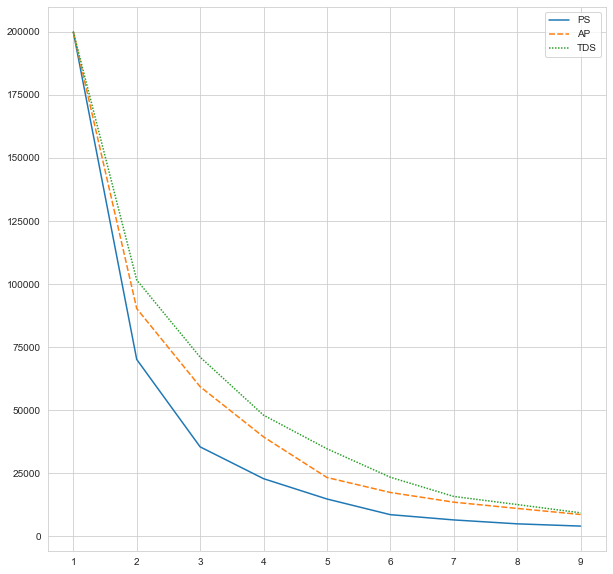

In [66]:
#4 clusters should be ok for all 3 variables

df_ps = pd.DataFrame(data=sse_ps.values(), index=sse_ps.keys(), columns=['PS'])
df_ap = pd.DataFrame(data=sse_ap.values(), index=sse_ap.keys(), columns=['AP'])
df_tds = pd.DataFrame(data=sse_tds.values(), index=sse_tds.keys(), columns=['TDS'])
inertias = df_ps.merge(df_ap, left_index=True, right_index=True, how='inner').merge(df_tds, left_index=True, right_index=True, how='inner')
plt.figure(figsize=(10,10))
sns.lineplot(data=inertias)

In [67]:
kmeans = KMeans(n_clusters=4)


kmeans.fit(hbw_16_clusters[['price_sens_colr_scaled']])
hbw_16_clusters['psCluster'] = kmeans.predict(hbw_16_clusters[['price_sens_colr_scaled']])

kmeans.fit(hbw_16_clusters[['apero_scaled']])
hbw_16_clusters['apCluster'] = kmeans.predict(hbw_16_clusters[['apero_scaled']])

kmeans.fit(hbw_16_clusters[['total_discount_scaled']])
hbw_16_clusters['discCluster'] = kmeans.predict(hbw_16_clusters[['total_discount_scaled']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

hbw_16_clusters = order_cluster('psCluster', 'price_sens_colr',hbw_16_clusters,False)
hbw_16_clusters = order_cluster('apCluster', 'apero',hbw_16_clusters,False)
hbw_16_clusters = order_cluster('discCluster', 'total_discount',hbw_16_clusters,False)
hbw_16_clusters.index = hbw_16_proc.index
hbw_16_clusters.groupby('psCluster')['price_sens_colr'].describe()

,count,mean,std,min,25%,50%,75%,max
psCluster,,,,,,,,
0,"37,301.00",0.07,0.13,-0.06,-0.02,0.03,0.11,0.90
1,"87,530.00",-0.19,0.07,-0.31,-0.25,-0.19,-0.13,-0.06
2,"52,480.00",-0.44,0.10,-0.71,-0.50,-0.42,-0.36,-0.31
3,"22,689.00",-0.98,0.07,-1.00,-1.00,-1.00,-1.00,-0.71


In [68]:
hbw_16_clusters.groupby('apCluster')['apero'].describe()

,count,mean,std,min,25%,50%,75%,max
apCluster,,,,,,,,
0,163.00,700.59,287.80,439.26,499.86,596.90,789.65,"1,896.87"
1,"6,169.00",175.29,56.93,119.18,134.31,156.67,196.57,437.20
2,"31,930.00",63.02,22.08,35.21,44.52,57.31,77.76,119.15
3,"161,738.00",7.38,9.23,-0.79,0.00,3.33,11.94,35.20


In [69]:
hbw_16_clusters.groupby('discCluster')['total_discount'].describe()

,count,mean,std,min,25%,50%,75%,max
discCluster,,,,,,,,
0,"184,313.00",-4.04,6.27,-29.90,-5.28,-1.10,0.00,0.06
1,"13,993.00",-55.75,23.07,-122.51,-68.59,-48.55,-37.09,-29.91
2,"1,675.00",-189.45,73.83,-623.37,-210.17,-165.17,-139.94,-122.56
3,19.00,"-1,120.35",774.33,"-4,112.49","-1,030.90",-955.37,-793.95,-695.19


In [70]:
#let's test again the baseline
hbw_16_proc_baseline = hbw_16_proc.drop(columns=['HOUSEHOLDTYPOLOGY']).dropna()
#hbw_16_proc_baseline = hbw_16_proc.dropna()
extra_cols = ['psCluster', 'discCluster', 'apCluster', 'apero']
#hbw_16_proc_baseline.drop(index=zeros, inplace=True, errors='ignore')

hbw_16_proc_baseline = hbw_16_proc_baseline.merge(hbw_16_clusters[extra_cols], left_index=True, right_index=True, how='left')
features_ap = features.copy()

#let's remove mobile, as values are always negative
features_ap.remove('cat_ColruytMobile_Toestellen')
features_ap = features_ap + extra_cols 


X_train, X_test, y_train, y_test = train_test_split(hbw_16_proc_baseline[features_ap].drop(columns=['bought_highbrow_wines']), 
                                                    hbw_16_proc_baseline['bought_highbrow_wines'], test_size=0.3, random_state=42)


sc = StandardScaler()
X_train = pd.DataFrame(data=sc.fit_transform(X_train), columns=hbw_16_proc_baseline[features_ap].drop(columns=['bought_highbrow_wines']).columns)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)


print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    131370
         1.0       0.22      0.78      0.35      6563

    accuracy                           0.86    137933
   macro avg       0.60      0.82      0.63    137933
weighted avg       0.95      0.86      0.89    137933

0.8213924928388902


In [71]:
coefficients = pd.concat([pd.DataFrame(hbw_16_proc_baseline[features_ap].drop(columns=['bought_highbrow_wines']).columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Var', 'Coef']
coefficients.sort_values(by='Coef', ascending=False)

,Var,Coef
48,rev_ticket,1.94
46,price_sens_colr,0.38
51,discCluster,0.35
52,apCluster,0.25
47,SOW_colr,0.23
37,cat_Tapas,0.19
30,cat_KaasSeizoenskazen,0.19
2,cat_AP_STDR_WhiskyONLINE,0.17
1,cat_AP_STDR_PortoONLINE,0.14
40,cat_Bot_Mar_Boter,0.13


In [72]:
#let's test again the baseline
#removing HHT, but flagging known "top demographic" (55+ no children) helps
#final test: let's work on the SOWs - this also helps quite a bit

hbw_16_proc_baseline = hbw_16_proc.drop(columns=['HOUSEHOLDTYPOLOGY']).dropna()
top_demographic = hbw_16_proc[hbw_16_proc['HOUSEHOLDTYPOLOGY'] == 'g_HHnochild_55_plus'].index
sow_over_100 = hbw_16_proc_baseline[hbw_16_proc_baseline['SOW_colr'] > 100].index

extra_cols = ['psCluster', 'discCluster', 'apCluster', 'apero']

hbw_16_proc_baseline = hbw_16_proc_baseline.merge(hbw_16_clusters[extra_cols], left_index=True, right_index=True, how='left')
features_ap = features.copy()
hbw_16_proc_baseline.loc[:, 'top_dem'] = np.where(hbw_16_proc_baseline.index.isin(top_demographic), 1, 0)
hbw_16_proc_baseline.drop(index=sow_over_100, inplace=True)

enc = OneHotEncoder(drop='first', sparse=False)
sowt = enc.fit_transform(hbw_16_proc.dropna(subset=['SOW_type_colr'])[['SOW_type_colr']])
socols = enc.get_feature_names()
sowts = pd.DataFrame(data=sowt, columns=socols, index=hbw_16_proc.dropna(subset=['SOW_type_colr']).index)

#let's remove mobile, as values are always negative
features_ap.remove('cat_ColruytMobile_Toestellen')
top_dem_col = ['top_dem']
features_ap = features_ap + extra_cols + top_dem_col
hbw_16_proc_baseline_model = hbw_16_proc_baseline[features_ap]
hbw_16_proc_baseline_model = hbw_16_proc_baseline_model.merge(sowts, how='left', right_index=True, left_index=True)


X_train, X_test, y_train, y_test = train_test_split(hbw_16_proc_baseline_model.drop(columns=['bought_highbrow_wines']), 
                                                    hbw_16_proc_baseline_model['bought_highbrow_wines'], test_size=0.3, random_state=42)


sc = StandardScaler()
X_train = pd.DataFrame(data=sc.fit_transform(X_train), columns=hbw_16_proc_baseline_model.drop(columns=['bought_highbrow_wines']).columns)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)


print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    123611
         1.0       0.22      0.80      0.34      5669

    accuracy                           0.86    129280
   macro avg       0.60      0.83      0.63    129280
weighted avg       0.96      0.86      0.90    129280

0.8331944617986493


# Feature engineering summary

What have we learned so far:
- we have some columns to remove: cat_ColruytMobile_Toestellen, HOUSEHOLDTYPOLOGY (but keeping the top dem)
- some new variables to create, and clustering to score by them
- few missing values to remove
- SOW > 100 values should be removed: it improves the baseline model quite a bit
- also, using the SOW types add value

# Modeling 

Let's now consolidate & standardize as much as possible all the steps in a pipeline so that we can reapply them as easily as possible to the test set without accidentally cheating


In [73]:
%%time
#let's create a series of steps to do some processing
#we don't create a pipeline because the winsorizer does not really like that, and there are not so many steps anyway

# create dfs for modeling
modeling_df16 = hbw_16.copy(deep=True)
modeling_df17 = hbw_17.copy(deep=True)

#drop rows which we really cannot keep
modeling_df16.dropna(subset=['bought_highbrow_wines', 'Collishop_customer', 'SOW_type_colr', 'SOW_colr'], inplace=True)
modeling_df17.dropna(subset=['Collishop_customer', 'SOW_type_colr', 'SOW_colr'], inplace=True)

#too high SOW
sows100plus16 = modeling_df16[modeling_df16['SOW_colr'] > 100].index
sows100plus17 = modeling_df17[modeling_df17['SOW_colr'] > 100].index
modeling_df16.drop(index=sows100plus16, inplace=True)
modeling_df17.drop(index=sows100plus17, inplace=True)

#top dem
topdem16 = modeling_df16[modeling_df16['HOUSEHOLDTYPOLOGY'] == 'g_HHnochild_55_plus'].index
topdem17 = modeling_df17[modeling_df17['HOUSEHOLDTYPOLOGY'] == 'g_HHnochild_55_plus'].index

modeling_df16['top_dem'] = np.where(modeling_df16.index.isin(topdem16), 1, 0)
modeling_df17['top_dem'] = np.where(modeling_df17.index.isin(topdem17), 1, 0)

#apero
apero_cols = ['cat_AP_STDR_WhiskyONLINE', 'cat_AP_STDR_PortoONLINE', 'cat_Tapas', 'cat_AP_STDR_WhiskyONLINE', 'cat_Bot_Mar_Boter']
modeling_df16['apero'] = np.sum(modeling_df16[apero_cols], axis=1)
modeling_df17['apero'] = np.sum(modeling_df17[apero_cols], axis=1)

#clustering columns
apero_cols = ['cat_AP_STDR_WhiskyONLINE', 'cat_AP_STDR_PortoONLINE', 'cat_Tapas', 'cat_AP_STDR_WhiskyONLINE', 'cat_Bot_Mar_Boter']
modeling_df16['apero'] = np.sum(modeling_df16[apero_cols], axis=1)
modeling_df17['apero'] = np.sum(modeling_df17[apero_cols], axis=1)

clust_cols = ['apero', 'price_sens_colr', 'total_discount']
modeling_df16_cluster = modeling_df16[clust_cols].copy()
modeling_df17_cluster = modeling_df17[clust_cols].copy()

sc_clust = StandardScaler()
modeling_df16_cluster = pd.DataFrame(sc_clust.fit_transform(modeling_df16_cluster), columns=modeling_df16_cluster.columns, index=modeling_df16_cluster.index)
modeling_df17_cluster = pd.DataFrame(sc_clust.transform(modeling_df17_cluster), columns=modeling_df17_cluster.columns, index=modeling_df17_cluster.index)

kmeans_ps = KMeans(n_clusters=4)
kmeans_ap = KMeans(n_clusters=4)
kmeans_td = KMeans(n_clusters=4)

kmeans_ps.fit(modeling_df16[['price_sens_colr']])
kmeans_ap.fit(modeling_df16[['apero']])
kmeans_td.fit(modeling_df16[['total_discount']])

modeling_df16_cluster['psCluster'] = kmeans_ps.predict(modeling_df16_cluster[['price_sens_colr']])
modeling_df16_cluster['apCluster'] = kmeans_ap.predict(modeling_df16_cluster[['apero']])
modeling_df16_cluster['tdCluster'] = kmeans_td.predict(modeling_df16_cluster[['total_discount']])

modeling_df17_cluster['psCluster'] = kmeans_ps.predict(modeling_df17_cluster[['price_sens_colr']])
modeling_df17_cluster['apCluster'] = kmeans_ap.predict(modeling_df17_cluster[['apero']])
modeling_df17_cluster['tdCluster'] = kmeans_td.predict(modeling_df17_cluster[['total_discount']])

modeling_df16 = modeling_df16.merge(modeling_df16_cluster.iloc[:,3:], left_index=True, right_index=True, how='inner')
modeling_df17 = modeling_df17.merge(modeling_df17_cluster.iloc[:,3:], left_index=True, right_index=True, how='inner')

#dropping bad columns
drop_cols = ['cat_ColruytMobile_Toestellen', 'HOUSEHOLDTYPOLOGY', 'jaar']

#dummy variables
dum_cols = ['Collishop_customer', 'SOW_type_colr']

dum_enc = OneHotEncoder(drop='first', sparse=False)

#quantitative columns for winsorizing to handle remaining outliers
non_quant = drop_cols + dum_cols + ['bought_highbrow_wines']
quant_cols = []

for col in modeling_df16.columns:
    if col not in non_quant:
        quant_cols.append(col)
        
#winsorize outliers
winsorizer = FunctionTransformer(scipy.stats.mstats.winsorize, kw_args={'axis': 0, 'inplace': False, 'limits': [0, 0.01]})

#winsorize does not work in pipeline, so let's apply it more traditionally
for col in quant_cols:
    modeling_df16[col] = scipy.stats.mstats.winsorize(a=modeling_df16[col], limits=0.005, inplace=True)
    modeling_df17[col] = scipy.stats.mstats.winsorize(a=modeling_df17[col], limits=0.005, inplace=True)
    
modeling_df16 = modeling_df16.drop(columns=(drop_cols))
modeling_df17 = modeling_df17.drop(columns=(drop_cols))

modeling_df16_dummies = pd.DataFrame(enc.fit_transform(modeling_df16[dum_cols]), columns=enc.get_feature_names(), index=modeling_df16.index)
modeling_df17_dummies = pd.DataFrame(enc.transform(modeling_df17[dum_cols]), columns=enc.get_feature_names(), index=modeling_df17.index)

modeling_df16_prepared = modeling_df16.drop(columns=dum_cols).merge(modeling_df16_dummies, left_index=True, right_index=True, how='inner')
modeling_df17_prepared = modeling_df17.drop(columns=dum_cols).merge(modeling_df17_dummies, left_index=True, right_index=True, how='inner')

sc = StandardScaler()
modeling_df16_prepared[quant_cols] = sc.fit_transform(modeling_df16_prepared[quant_cols])
modeling_df17_prepared[quant_cols] = sc.transform(modeling_df17_prepared[quant_cols])

if modeling_df16_prepared.isnull().sum().sum() > 0:
    raise ValueError('nulls present in prepared df')
else:
    print('no null values in prepared df')
    
    
X_train, X_test, y_train, y_test = train_test_split(modeling_df16_prepared.drop(columns=['bought_highbrow_wines']), 
                                                    modeling_df16_prepared['bought_highbrow_wines'], test_size=0.3, random_state=42)


no null values in prepared df
Wall time: 14.1 s


In [74]:
modeling_df16_prepared

,bought_highbrow_wines,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,cat_Bloemen,cat_Bot_Mar_Boter,cat_BroodKorthoudbaar,...,x1_SOW10-20,x1_SOW20-30,x1_SOW30-40,x1_SOW40-50,x1_SOW50-60,x1_SOW60-70,x1_SOW70-80,x1_SOW80-90,x1_SOW90-100,x1_SOW_100+
masked_customer_id,,,,,,,,,,,,,,,,,,,,,
339806,0.00,0.00,0.00,-0.24,-0.17,-0.19,-0.36,-0.26,-0.48,-0.19,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
339807,0.00,0.00,0.00,-0.24,-0.17,-0.19,-0.04,-0.26,-0.36,-0.39,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
339809,0.00,0.00,0.00,-0.24,2.98,0.60,-0.36,-0.26,-0.48,-0.39,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
339812,0.00,0.00,0.00,-0.24,-0.17,-0.19,-0.19,-0.26,-0.48,-0.22,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
339815,0.00,0.00,0.00,-0.24,-0.17,-0.19,0.05,2.99,-0.40,2.99,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8781244,1.00,0.00,0.00,-0.24,-0.17,-0.19,-0.36,-0.26,-0.48,-0.28,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
8783275,1.00,0.00,0.00,-0.24,-0.17,-0.19,-0.26,0.71,0.00,-0.39,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8786290,1.00,0.00,0.00,-0.24,-0.17,-0.19,-0.28,-0.26,-0.48,-0.39,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [75]:
modeling_df16_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187632 entries, 339806 to 8794346
Data columns (total 68 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   bought_highbrow_wines            187632 non-null  float64
 1   cat_AP_STDR_PortoONLINE          187632 non-null  float64
 2   cat_AP_STDR_WhiskyONLINE         187632 non-null  float64
 3   cat_Babyluiers                   187632 non-null  float64
 4   cat_Ber_Ger_DVPortioneerbaar     187632 non-null  float64
 5   cat_Ber_Ger_VersMaaltijdsalades  187632 non-null  float64
 6   cat_Bier_Genietbieren            187632 non-null  float64
 7   cat_Bloemen                      187632 non-null  float64
 8   cat_Bot_Mar_Boter                187632 non-null  float64
 9   cat_BroodKorthoudbaar            187632 non-null  float64
 10  cat_Chips                        187632 non-null  float64
 11  cat_DeegDV                       187632 non-null  float64
 

In [76]:
quant_cols

['cat_AP_STDR_PortoONLINE',
 'cat_AP_STDR_WhiskyONLINE',
 'cat_Babyluiers',
 'cat_Ber_Ger_DVPortioneerbaar',
 'cat_Ber_Ger_VersMaaltijdsalades',
 'cat_Bier_Genietbieren',
 'cat_Bloemen',
 'cat_Bot_Mar_Boter',
 'cat_BroodKorthoudbaar',
 'cat_Chips',
 'cat_DeegDV',
 'cat_EleKtroKeuken',
 'cat_Houtpelletskolen_briketten',
 'cat_Incontinentie_luiers',
 'cat_KaasSeizoenskazen',
 'cat_Kauwgum',
 'cat_KoudeSauzen',
 'cat_MelkKarnemelk',
 'cat_Notengedroogdfruit_groenten',
 'cat_Ontbijtgranen_Volwassenen',
 'cat_ParfumerieEHBO',
 'cat_Tapas',
 'cat_Textiel_Bedlinnen',
 'cat_Textiel_Herenondergoed',
 'cat_Textiel_Pantys',
 'cat_VNCBGBereidegerechten',
 'cat_VNCBerBurgers',
 'cat_VNCCharBHWildpasteien',
 'cat_VNCFSalades',
 'cat_VNCGevgeheel',
 'cat_VNCKalfStoofvlees',
 'cat_VNCLamSnedenkoteletsteak',
 'cat_VNCRest',
 'cat_VNCVarkenRest',
 'cat_VNCWildSteak',
 'cat_VerseKaasFruitkazen',
 'cat_VisGerookt',
 'cat_VisVerseSchelpdieren',
 'cat_Wijn_Stillewijnen_RAYON',
 'cat_Zomerspeelgoed',
 'cat_b

In [77]:
%%time
#let's take again a look at our baseline

clf = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)


print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    125319
         1.0       0.22      0.80      0.35      6023

    accuracy                           0.86    131342
   macro avg       0.61      0.83      0.64    131342
weighted avg       0.95      0.86      0.90    131342

0.8332316906832048
Wall time: 24.2 s


In [78]:
modeling_df16_dummies

,x0_Y,x1_Outlier_fr,x1_SOW00-10,x1_SOW10-20,x1_SOW20-30,x1_SOW30-40,x1_SOW40-50,x1_SOW50-60,x1_SOW60-70,x1_SOW70-80,x1_SOW80-90,x1_SOW90-100,x1_SOW_100+
masked_customer_id,,,,,,,,,,,,,
339806,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
339807,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
339809,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
339812,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
339815,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8781244,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
8783275,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8786290,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [79]:
%%time
#let's try with something a bit more powerful

outcome = 'bought_highbrow_wines'

default_wt = 1 / np.mean(y_train)
wt = [default_wt if outcome == 1 else 1 for outcome in y_train]
sum(wt)/len(wt)

import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=4,
    nthread=None,
    gamma=5,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=0,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=42,
    use_label_encoder=False,
    eval_metric  = 'logloss',
    missing = np.NaN
)

xgb_dmat = xgb.DMatrix(X_train, label=y_train)

xgb_model.fit(X_train, y_train, sample_weight=wt)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))

y_pred = xgb_model.predict(X_train)
print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))


Accuracy of XGB classifier on training set: 0.82
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90    125319
         1.0       0.19      0.89      0.31      6023

    accuracy                           0.82    131342
   macro avg       0.59      0.85      0.61    131342
weighted avg       0.96      0.82      0.87    131342

0.8539274846798838
Wall time: 32 s


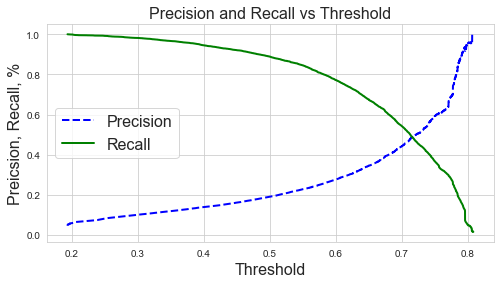

In [80]:
#we now have a model with ~50% precision and recall. We can rival a monkey!
from sklearn.metrics import precision_recall_curve

preds = xgb_model.predict_proba(X_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, preds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [81]:
features = X_train.columns
target = y_train

In [82]:
clf = lgbm.LGBMClassifier(objective="binary")

In [83]:
%%time
#stolen with pride from here: https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997
#and https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#baseline lgbm, leaving last ~8k records as holdout sample, to make sure we have a "clean" test set

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import time

N_SPLITS = 5
strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

modeling_df16_prepared_lgb = modeling_df16_prepared.iloc[:170000,:]

X = modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines']).reset_index().drop(columns=['masked_customer_id'])
y = modeling_df16_prepared_lgb.reset_index().drop(columns=['masked_customer_id'])['bought_highbrow_wines']

    
scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
    print("=" * 12 + f"Training fold {idx}" + 12 * "=")
    start = time.time()

    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    eval_set = [(X_val, y_val)]

    lgbm_clf = lgbm.LGBMClassifier(n_estimators=10000, n_jobs=4)
    lgbm_clf.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric="binary_logloss",
        callbacks=[lgbm.early_stopping(1000), lgbm.log_evaluation(1000)]
    )

    preds = lgbm_clf.predict_proba(X_val)
    loss = log_loss(y_val, preds)
    scores[idx] = loss
    runtime = time.time() - start
    print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")

============Training fold 0============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.104257
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.0977025
Fold 0 finished with score: 0.09770 in 19.70 seconds.

============Training fold 1============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.108991
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.0995309
Fold 1 finished with score: 0.09953 in 19.79 seconds.

============Training fold 2============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.103963
Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.0959789
Fold 2 finished with score: 0.09598 in 18.90 seconds.

============Training fold 3============
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's binary_logloss: 0.10453
Early stopping, best iter

In [84]:
#test on full training data
preds_clf = (lgbm_clf.predict(modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines'])))

print("ROC AUC score: {:<8.5f}".format(roc_auc_score(preds_clf, modeling_df16_prepared_lgb['bought_highbrow_wines'])))

print(classification_report(modeling_df16_prepared_lgb['bought_highbrow_wines'], preds_clf))

ROC AUC score: 0.92710 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    162818
         1.0       0.88      0.43      0.58      7182

    accuracy                           0.97    170000
   macro avg       0.93      0.71      0.78    170000
weighted avg       0.97      0.97      0.97    170000



In [85]:
#test on full holdout sample data
preds_clf_ho = (lgbm_clf.predict(modeling_df16_prepared.iloc[170000:,:].drop(columns=['bought_highbrow_wines'])))

print("ROC AUC score: {:<8.5f}".format(roc_auc_score(preds_clf_ho, modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'])))

print(classification_report(modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'], preds_clf_ho))
roc_clf = roc_auc_score(preds_clf_ho, modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'])

ROC AUC score: 0.93171 
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     16151
         1.0       0.92      0.33      0.48      1481

    accuracy                           0.94     17632
   macro avg       0.93      0.66      0.73     17632
weighted avg       0.94      0.94      0.93     17632



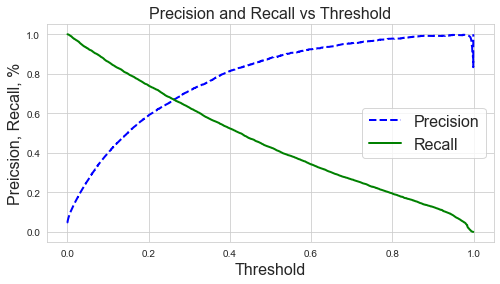

In [86]:
#and the monkey bites the dust!
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(modeling_df16_prepared_lgb['bought_highbrow_wines'], 
                                                         lgbm_clf.predict_proba(modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines']))[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [87]:
%%time
import optuna
from optuna.integration import LightGBMPruningCallback
from warnings import simplefilter

def objective(trial, X, y):
    param_grid = {
#        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart', 'rf']),
        "n_estimators": trial.suggest_int("n_estimators",1000, 15000, step=1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50, step=2),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 15, step=5),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 15, step=5),
        "class_weight": trial.suggest_categorical("class_weight", ['balanced', None]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.7, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.7, 0.9, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", silent=True, n_jobs=4, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss"),
                lgbm.log_evaluation(0),
                lgbm.early_stopping(200)
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test, n_jobs=4)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)

simplefilter("ignore", category=UserWarning)

#here we show 3 for simplicity, but below the result for 100
study.optimize(func, n_trials=3)

[I 2022-03-25 14:38:30,680] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] min_gain_to_split is set=5.732676602511123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.732676602511123
[LightGBM] [Warning] bagging_fraction is set=0.8999999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8999999999999999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.103171
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] min_gain_to_split is set=5.732676602511123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.73267660251

[I 2022-03-25 14:39:11,063] Trial 0 finished with value: 0.10373399096349727 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 3000, 'learning_rate': 0.28634088972306115, 'num_leaves': 10, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 10, 'class_weight': None, 'min_gain_to_split': 5.732676602511123, 'bagging_fraction': 0.8999999999999999, 'bagging_freq': 1, 'feature_fraction': 0.7999999999999999}. Best is trial 0 with value: 0.10373399096349727.


Early stopping, best iteration is:
[686]	valid_0's binary_logloss: 0.103869
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.688431842791492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.688431842791492
[LightGBM] [Warning] bagging_fraction is set=0.7999999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7999999999999999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4808]	valid_0's binary_logloss: 0.152762
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.688431842791492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_sp

[I 2022-03-25 14:46:00,183] Trial 1 finished with value: 0.15230037238054725 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 12000, 'learning_rate': 0.13312688920604726, 'num_leaves': 50, 'max_depth': 6, 'lambda_l1': 10, 'lambda_l2': 15, 'class_weight': 'balanced', 'min_gain_to_split': 0.688431842791492, 'bagging_fraction': 0.7999999999999999, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.10373399096349727.


[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] min_gain_to_split is set=11.348774925333604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.348774925333604
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.437893
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] min_gain_to_split is set=11.348774925333604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.348774925333604
[LightGBM] [Warning] b

[I 2022-03-25 14:46:29,405] Trial 2 finished with value: 0.4390972762579605 and parameters: {'boosting_type': 'rf', 'n_estimators': 2000, 'learning_rate': 0.12478366185433445, 'num_leaves': 14, 'max_depth': 18, 'lambda_l1': 10, 'lambda_l2': 5, 'class_weight': 'balanced', 'min_gain_to_split': 11.348774925333604, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.10373399096349727.


Wall time: 7min 59s


In [88]:
print(f"\tBest value (logloss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}") 

	Best value (logloss): 0.10373
	Best params:
		boosting_type: gbdt
		n_estimators: 3000
		learning_rate: 0.28634088972306115
		num_leaves: 10
		max_depth: 4
		lambda_l1: 10
		lambda_l2: 10
		class_weight: None
		min_gain_to_split: 5.732676602511123
		bagging_fraction: 0.8999999999999999
		bagging_freq: 1
		feature_fraction: 0.7999999999999999


In [89]:
%%time
#lgbm_best = lgbm.LGBMClassifier(objective="binary", **study.best_params)

lgbm_best = lgbm.LGBMClassifier(objective="binary", 		
                                    boosting_type='gbdt',
                                    n_estimators= 8000,
                                    learning_rate= 0.13132478409476467,
                                    num_leaves= 38,
                                    max_depth= 19,
                                    lambda_l1= 0,
                                    lambda_l2= 5,
                                    class_weight= None,
                                    min_gain_to_split= 1.9102572802408346,
                                    bagging_fraction= 0.7,
                                    bagging_freq= 1,
                                    feature_fraction= 0.7999999999999999)

lgbm_best.fit(modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines']), modeling_df16_prepared_lgb['bought_highbrow_wines'])

[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] min_gain_to_split is set=1.9102572802408346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9102572802408346
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Wall time: 1min 15s


LGBMClassifier(bagging_fraction=0.7, bagging_freq=1,
               feature_fraction=0.7999999999999999, lambda_l1=0, lambda_l2=5,
               learning_rate=0.13132478409476467, max_depth=19,
               min_gain_to_split=1.9102572802408346, n_estimators=8000,
               num_leaves=38, objective='binary')

In [90]:
#test new model on full training data
preds_best = (lgbm_best.predict(modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines'])))

print("ROC AUC score: {:<8.5f}".format(roc_auc_score(preds_best, modeling_df16_prepared_lgb['bought_highbrow_wines'])))

print(classification_report(modeling_df16_prepared_lgb['bought_highbrow_wines'], preds_best))

ROC AUC score: 0.95405 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    162818
         1.0       0.93      0.57      0.70      7182

    accuracy                           0.98    170000
   macro avg       0.95      0.78      0.85    170000
weighted avg       0.98      0.98      0.98    170000



In [91]:
#test on full holdout sample data
preds_best_ho = (lgbm_best.predict(modeling_df16_prepared.iloc[170000:,:].drop(columns=['bought_highbrow_wines'])))

roc_best = roc_auc_score(preds_best_ho, modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'])

print("ROC AUC score: {:<8.5f}".format(roc_auc_score(preds_best_ho, modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'])))
print("Different in ROC scores, best model vs baseline: {:<8.5f}".format(roc_best - roc_clf))


print(classification_report(modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'], preds_best_ho))

ROC AUC score: 0.93589 
Different in ROC scores, best model vs baseline: 0.00418 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     16151
         1.0       0.93      0.37      0.53      1481

    accuracy                           0.94     17632
   macro avg       0.94      0.68      0.75     17632
weighted avg       0.94      0.94      0.93     17632



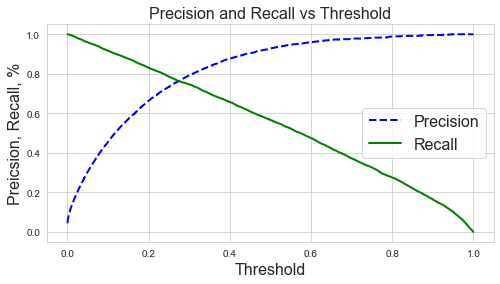

In [92]:
#looks good enough now
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds  = precision_recall_curve(modeling_df16_prepared_lgb['bought_highbrow_wines'], 
                                                         lgbm_best.predict_proba(modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines']))[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

C:\Users\PIETRO~1.RIN\AppData\Local\Temp/ipykernel_15208/1412238616.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


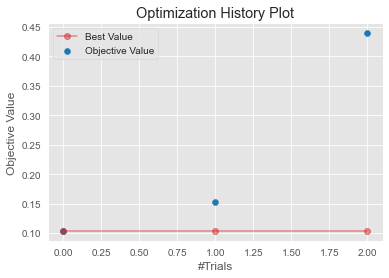

In [93]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

C:\Users\PIETRO~1.RIN\AppData\Local\Temp/ipykernel_15208/1756647795.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


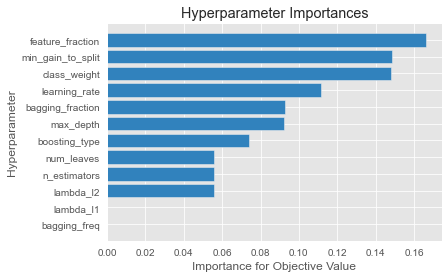

In [94]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

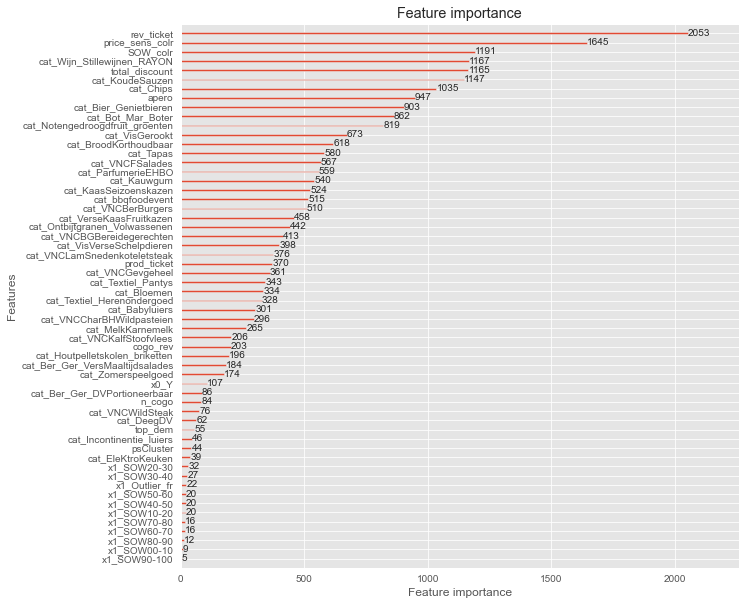

In [95]:
lgbm.plot_importance(lgbm_best, figsize=(10,10))

# Conclusion

We now have a satisfying model in terms of scores. Next step is choosing an appropriate precision / recall tradeoff. Intuitively, we'd want to have a decent precision, since the capacity to send mails is probably not unlimited.
Lacking business indications in that sense, we can take somewhere near the intersection of the precision / recall curves, then discuss further with the business as to whether they want a "larger or smaller fishing net", that is to say favor recall or precision.

In [96]:
#71% precision & recall. Looks good enough for a first output before prioritization



y_pred_t = lgbm_best.predict_proba(modeling_df16_prepared_lgb.drop(columns=['bought_highbrow_wines']))
thresh = 0.25
pred_2 = []

for x in y_pred_t:
    if x[1] >= thresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(modeling_df16_prepared_lgb['bought_highbrow_wines'], pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    162818
         1.0       0.73      0.79      0.76      7182

    accuracy                           0.98    170000
   macro avg       0.86      0.89      0.87    170000
weighted avg       0.98      0.98      0.98    170000

7699


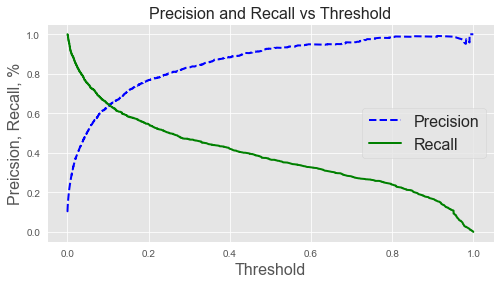

In [97]:
#let's see how thresholds look like in the test data - there's a drop in scores, suggesting we might, potentially increase regularization
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds  = precision_recall_curve(modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'], 
                                                         lgbm_best.predict_proba(modeling_df16_prepared.iloc[170000:,:].drop(columns=['bought_highbrow_wines']))[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [98]:
#deviation in test scores, let's focus on precision

y_pred_t = lgbm_best.predict_proba(modeling_df16_prepared.iloc[170000:,:].drop(columns=['bought_highbrow_wines']))
thresh = 0.23
pred_2 = []

for x in y_pred_t:
    if x[1] >= thresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(modeling_df16_prepared.iloc[170000:,:]['bought_highbrow_wines'], pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     16151
         1.0       0.79      0.52      0.62      1481

    accuracy                           0.95     17632
   macro avg       0.87      0.75      0.80     17632
weighted avg       0.94      0.95      0.94     17632

976


In [99]:
#predict on 2017 data
modeling_df17_prepared['preds_proba'] = lgbm_best.predict_proba(modeling_df17_prepared)[:,1]
modeling_df17_prepared['preds'] = np.where(modeling_df17_prepared['preds_proba'] > 0.25,1 ,0)

In [100]:
modeling_df17_prepared['preds'].value_counts()

0    178847
1      9557
Name: preds, dtype: int64

In [101]:
modeling_df17_prepared[['preds']].to_csv(os.path.join(output,r'hbw_17_predictions_v2.csv'))